In [22]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
import csv
import itertools
import os
import random
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold
from sklearn.kernel_ridge import KernelRidge
from sympy import symbols, simplify, lambdify, Function, diff, Mul
from sklearn.metrics import mean_squared_error
import math
from scipy.stats import pearsonr

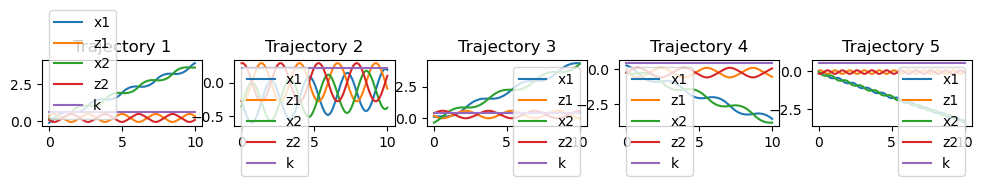

In [17]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import csv
def normalize(vector):
    norm = np.linalg.norm(vector)
    if norm == 0: 
        return vector
    return vector / norm
def normalized_system(y, t):
    x1, z1, x2, z2, k = y
    f = np.array([
        z1, 
        2 * k * (x2 - x1),
        z2, 
        2 * k * (x1 - x2), 
        0   
    ])
    normalized_f = normalize(f)
    return normalized_f
num_trajectories = 5
t = np.linspace(0, 10, 200)
trajectory_data = []
initial_conditions = [
    [-0.10036790492211001, 0.36057144512793293, 0.18559515344912403, 0.07892678735762926, 0.6506676052501416],
    [-0.2751850876460508, -0.2752043837310379, -0.35353311026544043, 0.29294091661994814, 0.22554447458683766],
    [0.08089200939456703, 0.16645806223683635, -0.3835324045633581, 0.37592788172959546, 0.3629301836816964],
    [0.2659541126403374, -0.2301287114573791, -0.2545400262343195, -0.25327639211725295, 0.4297256589643226],
    [-0.15660620563236982, 0.01980514530579025, -0.05444398508630738, -0.16701668784156648, 0.5104629857953323]
]
for r in range(num_trajectories):
    initial_condition = initial_conditions[r]
    sol = odeint(normalized_system, initial_condition, t)
    trajectory_data.append(sol)
with open('P1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['x1', 'z1', 'x2', 'z2', 'k', 'trajectory'])   
    for r, data in enumerate(trajectory_data):
        for j in range(len(t)):
            x1 = data[j, 0]
            z1 = data[j, 1]
            x2 = data[j, 2]
            z2 = data[j, 3]
            k = data[j, 4]
            writer.writerow([x1, z1, x2, z2, k, r+1])
plt.figure(figsize=(12, 8))
for r in range(num_trajectories):
    plt.subplot(8, num_trajectories, r+1)
    plt.plot(t, trajectory_data[r][:, 0], label='x1')
    plt.plot(t, trajectory_data[r][:, 1], label='z1')
    plt.plot(t, trajectory_data[r][:, 2], label='x2')
    plt.plot(t, trajectory_data[r][:, 3], label='z2')
    plt.plot(t, trajectory_data[r][:, 4], label='k')
    plt.title(f'Trajectory {r+1}')
    plt.legend()

In [335]:
data = np.genfromtxt('P1.csv', delimiter=',', names=True)
training_data = []
holdout_data = []
for r in range(1, 6):
    trajectory_subset = data[data['trajectory'] == r]
    train_set, holdout_set = train_test_split(trajectory_subset, test_size=0.2, random_state=42)
    training_data.extend(train_set)
    holdout_data.extend(holdout_set)
with open('trainingp_data.csv', 'w', newline='') as trainfile:
    writer = csv.writer(trainfile)
    writer.writerow(['x1', 'z1', 'x2', 'z2', 'k', 'trajectory'])
    for row in training_data:
        writer.writerow([row['x1'], row['z1'], row['x2'], row['z2'], row['k'], row['trajectory']])
with open('holdoutp_data.csv', 'w', newline='') as holdfile:
    writer = csv.writer(holdfile)
    writer.writerow(['x1', 'z1', 'x2', 'z2', 'k', 'trajectory'])
    for row in holdout_data:
        writer.writerow([row['x1'], row['z1'], row['x2'], row['z2'], row['k'], row['trajectory']])

In [336]:
import csv
import random
trajectories = {1: [], 2: [], 3: [], 4: [], 5: []}
with open('trainingp_data.csv', 'r') as trainfile:
    reader = csv.DictReader(trainfile)
    for row in reader:
        x1 = float(row['x1'])
        z1 = float(row['z1'])
        x2 = float(row['x2'])
        z2 = float(row['z2'])
        k = float(row['k'])
        trajectory = float(row['trajectory'])
        trajectories[trajectory].append({'x1': x1, 'z1': z1, 'x2': x2, 'z2': z2, 'k': k, 'trajectory': trajectory})
for traj_points in trajectories.values():
    random.shuffle(traj_points)
num_points_per_file = len(trajectories[1]) // 5
for i in range(5):
    output_filename = f'B{i+1}.csv'
    with open(output_filename, 'w', newline='') as output_file:
        writer = csv.writer(output_file)
        writer.writerow(['x1', 'z1', 'x2', 'z2', 'k', 'trajectory'])
        for trajectory in range(1, 6):
            points = trajectories[trajectory][i * num_points_per_file: (i + 1) * num_points_per_file]
            for point in points:
                writer.writerow([point['x1'], point['z1'], point['x2'], point['z2'], point['k'], point['trajectory']])

In [337]:
import numpy as np
import sympy as sp
from cvxopt import matrix, solvers
from qpsolvers import solve_qp
def compute_kernel_matrix(X, c, d):
    n = X.shape[0]
    K = (c + np.dot(X, X.T)) ** d
    return K
def solve_for_lambda(data, c, d, lambda_value):
    K = compute_kernel_matrix(data, c, d)
    I = np.eye(K.shape[0])
    K_with_I = K + lambda_value * I
    K_with_I_inv = np.linalg.inv(K_with_I)
    y0, y1, y2, y3, y4 = sp.symbols('y0 y1 y2 y3 y4')
    y = sp.Matrix([y0, y1, y2, y3, y4])  
    M_matrix = sp.Matrix(K_with_I_inv)
    n = K.shape[0]
    m = 5
    M = sp.zeros(n, m)
    for i in range(n):
        for j in range(m):
            start_idx = j * 80
            end_idx = (j + 1) * 80
            M[i, j] = sp.Add(*M_matrix[i, start_idx:end_idx])
    M_transpose = M.transpose()
    A = M_transpose @ M 
    A_np = np.array(A).astype(np.float64)
    return A_np
data = np.loadtxt('B1.csv', delimiter=',', skiprows=1, usecols=(0, 1, 2, 3, 4))
data2 = np.loadtxt('B2.csv', delimiter=',', skiprows=1, usecols=(0, 1, 2, 3, 4))
data3 = np.loadtxt('B3.csv', delimiter=',', skiprows=1, usecols=(0, 1, 2, 3, 4))
data4 = np.loadtxt('B4.csv', delimiter=',', skiprows=1, usecols=(0, 1, 2, 3, 4))
solutions_combined = []
for i in range(0, 8):
    lambda_value = 10**(-i)
    A1_np = solve_for_lambda(data, c=1, d=3, lambda_value=lambda_value)
    A2_np = solve_for_lambda(data2, c=1, d=3, lambda_value=lambda_value)
    A3_np = solve_for_lambda(data3, c=1, d=3, lambda_value=lambda_value)
    A4_np = solve_for_lambda(data4, c=1, d=3, lambda_value=lambda_value)
    As_p = (A1_np + A2_np + A3_np + A4_np)
    P = np.array(As_p)
    q = np.zeros(5)
    a = np.random.uniform(-4, 4, 5)
    G = np.zeros((0, 5))
    h = np.zeros(0)
    A = a.reshape(1, -1)
    b = np.array([1.0])
    y = solve_qp(P, q, G, h, A, b, solver="clarabel")
    y_opt = y.flatten() if isinstance(y, np.ndarray) else np.array(y).flatten()
    y_names = ['y0', 'y1', 'y2', 'y3', 'y4']
    y_dict = {name: value for name, value in zip(y_names, y_opt)}
    solutions_combined.append((lambda_value, y_dict))
    print(f"Lambda: {lambda_value}")
    print(y_dict)
print("\nAll Solutions Combined:")
for lambda_value, solution in solutions_combined:
#     print(f"Lambda: {lambda_value}")
    print(solution)
print("\nRandom vector a:")
print(a)

C:\Users\mebratie\anaconda3\lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:24: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
C:\Users\mebratie\anaconda3\lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:24: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
C:\Users\mebratie\anaconda3\lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:24: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


Lambda: 1
{'y0': -0.5722582825965233, 'y1': -0.3879561951592256, 'y2': -0.45612079703224306, 'y3': -0.45034756790287456, 'y4': -0.4846045394124043}
Lambda: 0.1
{'y0': 0.27837421078100644, 'y1': 0.16804641962978747, 'y2': 0.18501220758431627, 'y3': 0.24818595327685536, 'y4': 0.25662583241914466}
Lambda: 0.01
{'y0': -0.13478041765063167, 'y1': -0.011379895895829096, 'y2': -0.2759844839439368, 'y3': 0.35355487526913065, 'y4': 0.1976739053168035}
Lambda: 0.001
{'y0': -0.19534720489334736, 'y1': -0.097232124954359, 'y2': -0.1384468415289797, 'y3': -0.11657502835137844, 'y4': -0.14074853908370075}
Lambda: 0.0001
{'y0': -0.7384232402117277, 'y1': -0.4270568687705667, 'y2': -0.5007735680549471, 'y3': -0.5967412770912965, 'y4': -0.6426352630343551}
Lambda: 1e-05
{'y0': 0.09753285298875156, 'y1': 0.05225828991083497, 'y2': 0.06594492426458301, 'y3': 0.07111829954642301, 'y4': 0.07926382200342728}
Lambda: 1e-06
{'y0': 0.042697749532922734, 'y1': -0.07343661464091195, 'y2': 0.023837037702825147, '

In [57]:
def compute_kernel_matrix(X, c, d):
    n = X.shape[0]
    K = (c + np.dot(X, X.T)) ** d
    return K
def solve_for_lambda(data, c, d, lambda_value, y_values):
    K = compute_kernel_matrix(data, c, d)
    I = np.eye(K.shape[0])
    K_with_I = K + lambda_value * I
    K_with_I_inv = np.linalg.inv(K_with_I)
    y_repeated = np.repeat(y_values, len(data) // len(y_values))
    alpha_sym = K_with_I_inv @ y_repeated
    return K_with_I_inv, alpha_sym
def generate_f_alpha_expression(alpha_sym, x1, z1, x2, z2, k, x_q1_sym, z_q1_sym, x_q2_sym, z_q2_sym, k_q_sym, c, d):
    f_alpha = 0
    for i in range(len(alpha_sym)):
        f_alpha += alpha_sym[i] * (c + (x1[i] * x_q1_sym) + (z1[i] * z_q1_sym) + (x2[i] * x_q2_sym) + (z2[i] * z_q2_sym) + (k[i] * k_q_sym)) ** d
    f_alpha_expanded = sp.expand(f_alpha)
    f_alpha_collected = sp.collect(f_alpha_expanded, (x_q1_sym, z_q1_sym, x_q2_sym, z_q2_sym, k_q_sym))
    return f_alpha_collected
def process_dataset(file_path, c, d, lambda_values, y_values_dicts):
    data = np.loadtxt(file_path, delimiter=',', skiprows=1, usecols=(0, 1, 2, 3, 4))
    x1, z1, x2, z2, k = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4]
    K_with_I_inv_list = []
    alpha_sym_list = []
    f_alpha_expression_list = []
    for lambda_val, (_, y_values_dict) in zip(lambda_values, y_values_dicts):
        K_with_I_inv, alpha_sym = solve_for_lambda(data, c, d, lambda_val, list(y_values_dict.values()))
        x_q1_sym, z_q1_sym, x_q2_sym, z_q2_sym, k_q_sym = sp.symbols('x1 z1 x2 z2 k')
        K_with_I_inv_list.append(K_with_I_inv)
        alpha_sym_list.append(alpha_sym)
        f_alpha_expression = generate_f_alpha_expression(alpha_sym, x1, z1, x2, z2, k, x_q1_sym, z_q1_sym, x_q2_sym, z_q2_sym, k_q_sym, c, d)
        f_alpha_expression_list.append(f_alpha_expression)    
    return K_with_I_inv_list, alpha_sym_list, f_alpha_expression_list
lamda = 8
c, d = 1, 3
lambda_values = [10**(-i) for i in range(lamda)]
y_values_dicts_list = solutions_combined
file_path_1 = "B1.csv"
file_path_2 = "B2.csv"
file_path_3 = "B3.csv"
file_path_4 = "B4.csv"
B501_data = pd.read_csv('B1.csv')
dr1 = pd.read_csv("B5.csv")
traj_len = B501_data.groupby('trajectory').size()
rep4 = int(round(traj_len.mean()))
K_with_I_inv_1, alpha_sym_1, f_alpha_expression_1 = process_dataset(file_path_1, c, d, lambda_values, y_values_dicts_list)
K_with_I_inv_2, alpha_sym_2, f_alpha_expression_2 = process_dataset(file_path_2, c, d, lambda_values, y_values_dicts_list)
K_with_I_inv_3, alpha_sym_3, f_alpha_expression_3 = process_dataset(file_path_3, c, d, lambda_values, y_values_dicts_list)
K_with_I_inv_4, alpha_sym_4, f_alpha_expression_4 = process_dataset(file_path_4, c, d, lambda_values, y_values_dicts_list)
f_vector1_0, f_vector1_1, f_vector1_2, f_vector1_3, f_vector1_4, f_vector1_5, f_vector1_6, f_vector1_7 = [], [], [], [], [], [], [], []
for index, row in dr1.iterrows():
    value1_0, value1_1 = eval(str(f_alpha_expression_1[0]), globals(), row.to_dict()), eval(str(f_alpha_expression_1[1]), globals(), row.to_dict())
    value1_2, value1_3 = eval(str(f_alpha_expression_1[2]), globals(), row.to_dict()), eval(str(f_alpha_expression_1[3]), globals(), row.to_dict())
    value1_4, value1_5 = eval(str(f_alpha_expression_1[4]), globals(), row.to_dict()), eval(str(f_alpha_expression_1[5]), globals(), row.to_dict())
    value1_6, value1_7 = eval(str(f_alpha_expression_1[6]), globals(), row.to_dict()), eval(str(f_alpha_expression_1[7]), globals(), row.to_dict())
    f_vector1_0.append(value1_0),f_vector1_1.append(value1_1),f_vector1_2.append(value1_2),f_vector1_3.append(value1_3), f_vector1_4.append(value1_4), f_vector1_5.append(value1_5), f_vector1_6.append(value1_6), f_vector1_7.append(value1_7)
f_vector2_0, f_vector2_1, f_vector2_2, f_vector2_3, f_vector2_4, f_vector2_5, f_vector2_6, f_vector2_7 = [], [], [], [], [], [], [], []
for index, row in dr1.iterrows():
    value2_0, value2_1 = eval(str(f_alpha_expression_2[0]), globals(), row.to_dict()), eval(str(f_alpha_expression_2[1]), globals(), row.to_dict())
    value2_2, value2_3 = eval(str(f_alpha_expression_2[2]), globals(), row.to_dict()), eval(str(f_alpha_expression_2[3]), globals(), row.to_dict())
    value2_4, value2_5 = eval(str(f_alpha_expression_2[4]), globals(), row.to_dict()), eval(str(f_alpha_expression_2[5]), globals(), row.to_dict())
    value2_6, value2_7 = eval(str(f_alpha_expression_2[6]), globals(), row.to_dict()), eval(str(f_alpha_expression_2[7]), globals(), row.to_dict())
    f_vector2_0.append(value2_0),f_vector2_1.append(value2_1),f_vector2_2.append(value2_2),f_vector2_3.append(value2_3),f_vector2_4.append(value2_4),f_vector2_5.append(value2_5),f_vector2_6.append(value2_6),f_vector2_7.append(value2_7)
f_vector3_0, f_vector3_1, f_vector3_2, f_vector3_3, f_vector3_4, f_vector3_5, f_vector3_6, f_vector3_7 = [], [], [], [], [], [], [], []
for index, row in dr1.iterrows():
    value3_0, value3_1 = eval(str(f_alpha_expression_3[0]), globals(), row.to_dict()), eval(str(f_alpha_expression_3[1]), globals(), row.to_dict())
    value3_2, value3_3 = eval(str(f_alpha_expression_3[2]), globals(), row.to_dict()), eval(str(f_alpha_expression_3[3]), globals(), row.to_dict())
    value3_4, value3_5 = eval(str(f_alpha_expression_3[4]), globals(), row.to_dict()), eval(str(f_alpha_expression_3[5]), globals(), row.to_dict())
    value3_6, value3_7 = eval(str(f_alpha_expression_3[6]), globals(), row.to_dict()), eval(str(f_alpha_expression_3[7]), globals(), row.to_dict())
    f_vector3_0.append(value3_0),f_vector3_1.append(value3_1),f_vector3_2.append(value3_2),f_vector3_3.append(value3_3),f_vector3_4.append(value3_4),f_vector3_5.append(value3_5),f_vector3_6.append(value3_6),f_vector3_7.append(value3_7),
f_vector4_0, f_vector4_1, f_vector4_2, f_vector4_3, f_vector4_4, f_vector4_5, f_vector4_6, f_vector4_7 = [], [], [], [], [], [], [], []
for index, row in dr1.iterrows():
    value4_0, value4_1 = eval(str(f_alpha_expression_4[0]), globals(), row.to_dict()), eval(str(f_alpha_expression_4[1]), globals(), row.to_dict())
    value4_2, value4_3 = eval(str(f_alpha_expression_4[2]), globals(), row.to_dict()), eval(str(f_alpha_expression_4[3]), globals(), row.to_dict())
    value4_4, value4_5 = eval(str(f_alpha_expression_4[4]), globals(), row.to_dict()), eval(str(f_alpha_expression_4[5]), globals(), row.to_dict())
    value4_6, value4_7 = eval(str(f_alpha_expression_4[6]), globals(), row.to_dict()), eval(str(f_alpha_expression_4[7]), globals(), row.to_dict())
    f_vector4_0.append(value4_0),f_vector4_1.append(value4_1),f_vector4_2.append(value4_2),f_vector4_3.append(value4_3),f_vector4_4.append(value4_4),f_vector4_5.append(value4_5),f_vector4_6.append(value4_6),f_vector4_7.append(value4_7)   
h1, h2, h3, h4 = list(y_values_dicts_list[0][1].values()), list(y_values_dicts_list[1][1].values()), list(y_values_dicts_list[2][1].values()), list(y_values_dicts_list[3][1].values())
h5, h6, h7, h8 = list(y_values_dicts_list[4][1].values()), list(y_values_dicts_list[5][1].values()), list(y_values_dicts_list[6][1].values()), list(y_values_dicts_list[7][1].values())
y_B501_0, y_B501_1, y_B501_2, y_B501_3, y_B501_4 = np.repeat(h1, rep4), np.repeat(h2, rep4), np.repeat(h3, rep4), np.repeat(h4, rep4), np.repeat(h5, rep4)
y_B501_5, y_B501_6, y_B501_7, y_B502_0, y_B502_1 = np.repeat(h6, rep4), np.repeat(h7, rep4), np.repeat(h8, rep4), np.repeat(h1, rep4), np.repeat(h2, rep4)
y_B502_2, y_B502_3, y_B502_4, y_B502_5, y_B502_6 = np.repeat(h3, rep4), np.repeat(h4, rep4), np.repeat(h5, rep4), np.repeat(h6, rep4), np.repeat(h7, rep4)
y_B502_7, y_B503_0, y_B503_1,y_B503_2, y_B503_3 = np.repeat(h8, rep4), np.repeat(h1, rep4), np.repeat(h2, rep4), np.repeat(h3, rep4), np.repeat(h4, rep4)
y_B503_4,y_B503_5, y_B503_6, y_B503_7, y_B504_0 = np.repeat(h5, rep4), np.repeat(h6, rep4), np.repeat(h7, rep4), np.repeat(h8, rep4), np.repeat(h1, rep4)
y_B504_1, y_B504_2, y_B504_3, y_B504_4, y_B504_5 = np.repeat(h2, rep4), np.repeat(h3, rep4), np.repeat(h4, rep4), np.repeat(h5, rep4), np.repeat(h6, rep4)
y_B504_6, y_B504_7 = np.repeat(h7, rep4), np.repeat(h8, rep4)
RMSE_1_0, RMSE_1_1 = np.sqrt(mean_squared_error(y_B501_0, f_vector1_0)), np.sqrt(mean_squared_error(y_B501_1, f_vector1_1))
RMSE_1_2, RMSE_1_3 = np.sqrt(mean_squared_error(y_B501_2, f_vector1_2)), np.sqrt(mean_squared_error(y_B501_3, f_vector1_3))
RMSE_1_4, RMSE_1_5 = np.sqrt(mean_squared_error(y_B501_4, f_vector1_4)), np.sqrt(mean_squared_error(y_B501_5, f_vector1_5))
RMSE_1_6, RMSE_1_7 = np.sqrt(mean_squared_error(y_B501_6, f_vector1_6)), np.sqrt(mean_squared_error(y_B501_7, f_vector1_7))
RMSE_2_0, RMSE_2_1 = np.sqrt(mean_squared_error(y_B502_0, f_vector2_0)), np.sqrt(mean_squared_error(y_B502_1, f_vector2_1))
RMSE_2_2, RMSE_2_3 = np.sqrt(mean_squared_error(y_B502_2, f_vector2_2)), np.sqrt(mean_squared_error(y_B502_3, f_vector2_3))
RMSE_2_4, RMSE_2_5 = np.sqrt(mean_squared_error(y_B502_4, f_vector2_4)), np.sqrt(mean_squared_error(y_B502_5, f_vector2_5))
RMSE_2_6, RMSE_2_7 = np.sqrt(mean_squared_error(y_B502_6, f_vector2_6)), np.sqrt(mean_squared_error(y_B502_7, f_vector2_7))
RMSE_3_0, RMSE_3_1 = np.sqrt(mean_squared_error(y_B503_0, f_vector3_0)), np.sqrt(mean_squared_error(y_B503_1, f_vector3_1))
RMSE_3_2, RMSE_3_3 = np.sqrt(mean_squared_error(y_B503_2, f_vector3_2)), np.sqrt(mean_squared_error(y_B503_3, f_vector3_3))
RMSE_3_4, RMSE_3_5 = np.sqrt(mean_squared_error(y_B503_4, f_vector3_4)), np.sqrt(mean_squared_error(y_B503_5, f_vector3_5))
RMSE_3_6, RMSE_3_7 = np.sqrt(mean_squared_error(y_B503_6, f_vector3_6)), np.sqrt(mean_squared_error(y_B503_7, f_vector3_7))
RMSE_4_0, RMSE_4_1 = np.sqrt(mean_squared_error(y_B504_0, f_vector4_0)), np.sqrt(mean_squared_error(y_B504_1, f_vector4_1))
RMSE_4_2, RMSE_4_3 = np.sqrt(mean_squared_error(y_B504_2, f_vector4_2)), np.sqrt(mean_squared_error(y_B504_3, f_vector4_3))
RMSE_4_4, RMSE_4_5 = np.sqrt(mean_squared_error(y_B504_4, f_vector4_4)), np.sqrt(mean_squared_error(y_B504_5, f_vector4_5))
RMSE_4_6, RMSE_4_7 = np.sqrt(mean_squared_error(y_B504_6, f_vector4_6)), np.sqrt(mean_squared_error(y_B504_7, f_vector4_7))
rmse_values = {
    "B501": [RMSE_1_0, RMSE_1_1, RMSE_1_2, RMSE_1_3, RMSE_1_4, RMSE_1_5, RMSE_1_6, RMSE_1_7],
    "B502": [RMSE_2_0, RMSE_2_1, RMSE_2_2, RMSE_2_3, RMSE_2_4, RMSE_2_5, RMSE_2_6, RMSE_2_7],
    "B503": [RMSE_3_0, RMSE_3_1, RMSE_3_2, RMSE_3_3, RMSE_3_4, RMSE_3_5, RMSE_3_6, RMSE_3_7],
    "B504": [RMSE_4_0, RMSE_4_1, RMSE_4_2, RMSE_4_3, RMSE_4_4, RMSE_4_5, RMSE_4_6, RMSE_4_7]
}
for file, rmse_list in rmse_values.items():
    min_rmse = min(rmse_list)
    min_index = rmse_list.index(min_rmse)
rmse_values = [RMSE_1_0, RMSE_1_1, RMSE_1_2, RMSE_1_3, RMSE_1_4, RMSE_1_5, RMSE_1_6, RMSE_1_7,
               RMSE_2_0, RMSE_2_1, RMSE_2_2, RMSE_2_3, RMSE_2_4, RMSE_2_5, RMSE_2_6, RMSE_2_7,
               RMSE_3_0, RMSE_3_1, RMSE_3_2, RMSE_3_3, RMSE_3_4, RMSE_3_5, RMSE_3_6, RMSE_3_7,
               RMSE_4_0, RMSE_4_1, RMSE_4_2, RMSE_4_3, RMSE_4_4, RMSE_4_5, RMSE_4_6, RMSE_4_7]
min_rmse = min(rmse_values)
min_index = rmse_values.index(min_rmse)
file_index = min_index // 8 + 1
sub_index = min_index % 8
h_values = [h1, h2, h3, h4, h5, h6, h7, h8]
lambda_values = [10**(-i) for i in range(lamda)]
h_value = h_values[sub_index]
df2 = pd.read_csv('trainingp_data.csv')
m = df2['trajectory'].nunique()
# df2['trajectory'] = df2['trajectory'].replace({1: h_value[0],2: h_value[1], 3: h_value[2], 4: h_value[3], 5: h_value[4]})
df2['trajectory'] = df2['trajectory'].replace({i: h_value[i-1] for i in range(1, m+1)})
X_train = df2.iloc[:, :-1]
y_train = df2.iloc[:, -1]
X_train.to_csv('X_train.csv', index=False)
y_train = y_train.astype(float)
X_train = X_train.astype(float)
def polynomial_kernel(X, Y, degree=d):
    return (1 + np.dot(X, Y.T)) ** degree
param_grid = {'alpha': [0.0000002, 0.000004, 0.00006, 0.0008, 0.002, 0.01, 0.2,1, 4, 10, 100]}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
kr_model = KernelRidge(kernel=polynomial_kernel)
grid_search = GridSearchCV(kr_model, param_grid, cv=cv, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)
print("")
print("")
class KernelMethodBase(object):
    '''
    Base class for kernel methods models
    Methods
    ----
    fit
    predict
    fit_K
    predict_K
    '''
    kernels_ = {
        'polynomial': polynomial_kernel,
    }
    def __init__(self, kernel='polynomial', **kwargs):
        self.kernel_name = kernel
        self.kernel_function_ = self.kernels_[kernel]
        self.kernel_parameters = self.get_kernel_parameters(**kwargs)
        self.fit_intercept_ = False
    def get_kernel_parameters(self, **kwargs):
        params = {}
        params['degree'] = kwargs.get('degree', 3)
        return params
    def fit_K(self, K, y, **kwargs):
        pass
    def decision_function_K(self, K):
        pass
    def fit(self, X, y, **kwargs):
        self.X_train = X
        self.y_train = y
        K = self.kernel_function_(self.X_train, self.X_train, **self.kernel_parameters)
        return self.fit_K(K, y, **kwargs)
    def decision_function(self, X):
        K_x = self.kernel_function_(X, self.X_train, **self.kernel_parameters)
        return self.decision_function_K(K_x)
    def predict(self, X):
        pass
    def predict_K(self, K):
        pass
class KernelRidgeRegression(KernelMethodBase):
    '''
    Kernel Ridge Regression
    '''
    def __init__(self, alpha=0.1, **kwargs):
        self.alpha = alpha
        super(KernelRidgeRegression, self).__init__(**kwargs)
    def fit_K(self, K, y):
        n = K.shape[0]
        assert (n == len(y))
        A = K + self.alpha*np.identity(n)
        self.eta = np.linalg.solve(A , y)
        return self
    def decision_function_K(self, K_x):
        return K_x.dot(self.eta)
    def predict(self, X):
        return self.decision_function(X)
    def predict_K(self, K_x):
        return self.decision_function_K(K_x)
kernel = 'polynomial'
kr_model = KernelRidgeRegression(
    kernel=kernel,
    alpha=grid_search.best_params_['alpha'],
    )
kr_model.fit(X_train, y_train)
eta = kr_model.eta
x1, z1, x2, z2, k = sp.symbols('x1 z1 x2 z2 k') # all variable
polynomial_kernel = (1 + x1*sp.Symbol('xi1') + z1*sp.Symbol('zi1') + x2*sp.Symbol('xi2') + z2*sp.Symbol('zi2') + k*sp.Symbol('ki'))**3
f_beta = 0
for i in range(len(X_train)):
    f_beta += eta[i] * polynomial_kernel.subs({'xi1': X_train.iloc[i][0], 'zi1': X_train.iloc[i][1], 'xi2': X_train.iloc[i][2], 'zi2': X_train.iloc[i][3], 'ki': X_train.iloc[i][4]})
candidate_CL = sp.expand(f_beta)
print("Candidate Conservation Law:")
sp.pprint(candidate_CL)

Best parameters: {'alpha': 2e-07}
Best RMSE: 2.6361414271002273e-19


Candidate Conservation Law:
                    3                        2                           2    
0.0528805011085452⋅k  + 4.47216321006888e-9⋅k ⋅x₁ + 3.91965678621028e-9⋅k ⋅x₂ 

                      2                          2                         2  
+ 0.0150182870353115⋅k ⋅z₁ + 0.0150182847286345⋅k ⋅z₂ + 0.271423229205098⋅k  +

                         2                                                    
 0.00642826118581159⋅k⋅x₁  - 0.0128565245588949⋅k⋅x₁⋅x₂ + 1.40828591481488e-8⋅

                                                                              
k⋅x₁⋅z₁ + 1.47719925952603e-8⋅k⋅x₁⋅z₂ - 8.27593058883372e-9⋅k⋅x₁ + 0.006428261

             2                                                                
51563662⋅k⋅x₂  + 1.27989710789391e-8⋅k⋅x₂⋅z₁ + 1.40625453477023e-8⋅k⋅x₂⋅z₂ - 8

                                                2                             
.6042204333614e-9⋅k⋅x₂ + 0.0

In [338]:
import numpy as np
import sympy as sp
def compute_kernel_matrix(X, c, d):
    n = X.shape[0]
    K = (c + np.dot(X, X.T)) ** d
    return K
def solve_for_lambda(data, c, d, lambda_value, y_values):
    K = compute_kernel_matrix(data, c, d)
    I = np.eye(K.shape[0])
    K_with_I = K + lambda_value * I
    K_with_I_inv = np.linalg.inv(K_with_I)
    y_repeated = np.repeat(y_values, len(data) // len(y_values))
    alpha_sym = K_with_I_inv @ y_repeated
    return K_with_I_inv, alpha_sym
def generate_f_alpha_expression(alpha_sym, x1, z1, x2, z2, k, x_q1_sym, z_q1_sym, x_q2_sym, z_q2_sym, k_q_sym, c, d):
    f_alpha = 0
    for i in range(len(alpha_sym)):
        f_alpha += alpha_sym[i] * (c + (x1[i] * x_q1_sym) + (z1[i] * z_q1_sym) + (x2[i] * x_q2_sym) + (z2[i] * z_q2_sym) + (k[i] * k_q_sym)) ** d
    f_alpha_expanded = sp.expand(f_alpha)
    f_alpha_collected = sp.collect(f_alpha_expanded, (x_q1_sym, z_q1_sym, x_q2_sym, z_q2_sym, k_q_sym))
    return f_alpha_collected
data = np.loadtxt('trainingp_data.csv', delimiter=',', skiprows=1, usecols=(0, 1, 2, 3, 4))
x1 = data[:, 0]
z1 = data[:, 1]
x2 = data[:, 2]
z2 = data[:, 3]
k = data[:, 4]
lambda_val = 10**(-7)
c = 1.0
d = 3
y_values_dict = {'y0': 0.042697749532922734, 'y1': -0.07343661464091195, 'y2': 0.023837037702825147, 'y3': -0.1479884326037253, 'y4': -0.0956832938924412}
K_with_I_inv, alpha_sym = solve_for_lambda(data, c, d, lambda_val, list(y_values_dict.values()))
x_q1_sym, z_q1_sym, x_q2_sym, z_q2_sym, k_q_sym = sp.symbols('x1 z1 x2 z2 k')
f_alpha_expression = generate_f_alpha_expression(alpha_sym, x1, z1, x2, z2, k, x_q1_sym, z_q1_sym, x_q2_sym, z_q2_sym, k_q_sym, c, d)
expanded_result = sp.expand(f_alpha_expression)
coefficients = list(expanded_result.as_coefficients_dict().values())
terms = list(expanded_result.as_coefficients_dict().keys())
filtered_terms = [term for coeff, term in zip(coefficients, terms) if abs(coeff) > 0.0001]
filtered_expression = sum(sp.Mul(coeff, term) for coeff, term in zip(coefficients, terms) if term in filtered_terms)
print("Collected f_alpha(x_q):")
print(f_alpha_expression)
print("Collected f_alpha(x_q) with terms having coefficients greater than 0.02:")
print(filtered_expression)

Collected f_alpha(x_q):
0.0172945950210543*k**3 + 0.0442705715634453*k**2 - 0.0122969227087696*k - 2.27835843058711e-6*x1**3 + x1**2*(0.0064632864614165*k + 5.66072806623729e-6*x2 + 1.68578663660038e-6*z1 - 1.7830080616979e-6*z2 - 1.68756639888309e-6) + x1*(-9.39618037281115e-7*k**2 - 0.0129267703288301*k*x2 + 4.69269955180634e-7*k*z1 - 1.81165477195801e-6*k*z2 - 1.72921131527887e-6*k - 6.7604882404604e-6*x2**2 - 6.75196480510346e-6*x2*z1 + 6.42607278562163e-6*x2*z2 + 3.18826035446227e-6*x2 - 2.62649366100148e-6*z1**2 + 6.09895831225591e-6*z1*z2 - 1.62033732076865e-6*z1 - 3.98977819635727e-6*z2**2 - 2.36859500494461e-7*z2 + 1.28437373281037e-6) + 1.99497102031023e-6*x2**3 + x2**2*(0.00646304375216498*k - 2.02984136407473e-6*z2 - 1.25868459291412e-6) + x2*(1.11313063544686e-6*k**2 + 2.31451796141877e-6*k*z2 + 1.62889999569997e-6*k + 3.97399163836777e-6*z2**2 + 2.02707762396708e-6*z2 - 2.71028918812566e-6) + 0.000736963192316849*z1**3 + z1**2*(0.0159138233533283*k + 2.81352007692956e-6*x

In [60]:
y_values_dict = {'y0': -0.46786231509232357, 'y1': -0.051422908673102175, 'y2': -0.20754612299041875, 'y3': 0.1842015484513335, 'y4': -0.08474754107219783}
df = pd.read_csv('holdoutp_data.csv')
def evaluate_expression(eval_function, x1_val, z1_val, x2_val, z2_val, k_val):
    return eval_function(x1_val, z1_val, x2_val, z2_val, k_val)
eval_expression = sp.lambdify(('x1', 'z1', 'x2', 'z2', 'k'), f_alpha_expression, modules=['numpy'])
df['lamhold=10^{-7}'] = df.apply(lambda row: evaluate_expression(eval_expression, row['x1'], row['z1'], row['x2'], row['z2'], row['k']), axis=1)
print("\nFinal DataFrame for holdoutp_data:")
values = list(y_values_dict.values())
repetitions = 40
coluh_values = [value for value in values for _ in range(repetitions)]
df['Coluh(lamhold=10^{-7})'] = coluh_values
columns_to_compare = [('lamhold=10^{-7}', 'Coluh(lamhold=10^{-7})')]
for col1, col2 in columns_to_compare:
    rmse = np.sqrt(mean_squared_error(df[col1], df[col2]))
    print(f'Generalisation Error (RMSE): {rmse}')
f = sp.lambdify((sp.symbols('x1'), sp.symbols('z1'), sp.symbols('x2'), sp.symbols('z2'), sp.symbols('k')), f_alpha_expression, 'numpy')
data = pd.read_csv('P1.csv')
trajectories = data['trajectory'].unique()
Delta_phi = 0
N = 200
for trajectory in trajectories:
    trajectory_data = data[data['trajectory'] == trajectory]
    x1_values = trajectory_data['x1']
    z1_values = trajectory_data['z1']
    x2_values = trajectory_data['x2']
    z2_values = trajectory_data['z2']
    k_values = trajectory_data['k']
    function_values = f(x1_values, z1_values, x2_values, z2_values, k_values)
    average_function_value = np.mean(function_values)
    Delta_phi += np.sum(((function_values - average_function_value)/average_function_value)**2)
M = len(trajectories)
Delta_phi /= (M * N)
sqrt_Delta_phi = np.sqrt(Delta_phi)
print(f"First Numerical Validation (Square Root of Delta(Phi)): {sqrt_Delta_phi}")


Final DataFrame for holdoutp_data:
Generalisation Error (RMSE): 3.4869383458164406e-05
First Numerical Validation (Square Root of Delta(Phi)): 1.1390907385481993e-05


In [2]:
# A=K\hat=(K+\lambda I)^(-1)
# F=k\hat^T=((K+\lambda I)^(-1))^T
import numpy as np
import sympy as sp
from cvxopt import matrix, solvers
from qpsolvers import solve_qp
def compute_kernel_matrix(X, c, d):
    n = X.shape[0]
    K = (c + np.dot(X, X.T)) ** d
    return K
def solve_for_lambda(data, c, d, lambda_value):
    K = compute_kernel_matrix(data, c, d)
    I = np.eye(K.shape[0])
    K_with_I = K + lambda_value * I
    K_with_I_inv = np.linalg.inv(K_with_I)
    M_matrix = sp.Matrix(K_with_I_inv)
    n = K.shape[0]
    m = 5
    M = sp.zeros(n, m)
    for i in range(n):
        for j in range(m):
            start_idx = j * 400
            end_idx = (j + 1) * 400
            M[i, j] = sp.Add(*M_matrix[i, start_idx:end_idx])
    M_transpose = M.transpose()
    A = M 
    F =A.T
    return A, K_with_I_inv, F
data = np.loadtxt('trainingp_data.csv', delimiter=',', skiprows=1, usecols=(0, 1, 2, 3, 4))
solutions_combined = []
for i in range(7, 8):
    lambda_value = 10**(-i)
    A, K_with_I_inv, F = solve_for_lambda(data, c=1, d=3, lambda_value=lambda_value)
    print(K_with_I_inv)
    print(A)
    print(F)
    print(K_with_I_inv.shape)
    print(A.shape)
    print(F.shape)

[[ 9.80313804e+06  8.94785149e+03 -6.93663904e+04 ...  2.06708786e+03
  -7.83994154e+03 -8.02594634e+03]
 [ 8.95762078e+03  9.67101933e+06 -2.34515843e+04 ... -3.88776295e+03
  -1.63611127e+02  1.16207269e+03]
 [-6.93695006e+04 -2.34709959e+04  9.57454884e+06 ...  9.76162273e+03
   6.35598423e+03  1.01707252e+04]
 ...
 [ 2.07184369e+03 -3.90291624e+03  9.72850415e+03 ...  9.87110547e+06
   1.58499024e+04 -1.22541865e+04]
 [-7.92583636e+03  7.31967567e+01  6.39522513e+03 ...  1.60809211e+04
   9.78309086e+06  4.61811190e+03]
 [-8.02730058e+03  1.14279094e+03  1.01723364e+04 ... -1.22548672e+04
   4.62719253e+03  9.87510522e+06]]
Matrix([[-4.57309852525214, -0.259165130944893, 15.7019855067847, -15.1730972739751, 7.28131527335790], [5.73537932112413, 2.91717099245398, 420.332536166200, 58.3944074144674, -34.9625959742007], [0.999945300864056, 3.10675474404889, 9.37959171176226, -33.8194345207362, -10.8063354334354], [-0.0253707300216774, -0.101309145014056, 17.7021734450855, -2.435162587

In [3]:
# Computing the coefficients and the monomials using multinomial expansion
import itertools
import math
import pandas as pd
import numpy as np
import sympy as sp
def multilinear_coefficient(n, *ks):
    numerator = math.factorial(n)
    denominator = 1
    for k in ks:
        denominator *= math.factorial(k)
    return numerator // denominator
def multilinear_expansion(variables, n, row):
    expansions = []
    for ks in itertools.product(range(n + 1), repeat=len(variables)):
        if sum(ks) == n:
            coefficient = multilinear_coefficient(n, *ks)
            values = [row[var] ** k if var != '1' else 1 for var, k in zip(variables, ks)]
            term_value = coefficient * math.prod(values)
            expansions.append(term_value)
    return expansions[::-1]
def multilinear_expansion1(variables1, n1):
    expansions1 = []  
    for ks in itertools.product(range(n1 + 1), repeat=len(variables1)):
        if sum(ks) == n1:
            terms1 = [f"{var}**{k}" if k != 0 else f"{var}" for var, k in zip(variables1, ks) if k != 0]
            term1 = " * ".join(terms1)
            expansions1.append(term1)
    return expansions1[::-1]
def generate_inner_products(coefficients, terms):
    inner_products = [f"{c}*{t}" for c, t in zip(coefficients, terms)]
    return inner_products
data = pd.read_csv('trainingp_data.csv')
variables = ['c', 'x1', 'z1', 'x2', 'z2', 'k'] 
n = 3
data['c'] = 1
variables1 = ['1', 'x1', 'z1', 'x2', 'z2', 'k']
n1 = 3
all_entries = []
for index, row in data.iterrows():
    result = multilinear_expansion(variables, n, row)
    result1 = multilinear_expansion1(variables1, n1)
    expressions = generate_inner_products(result, result1)
    all_entries.append(result)
matrix = np.array(all_entries)
print("Matrix shape:", matrix.shape)
print("Matrix of results:")
for i, row in enumerate(matrix):
    print(f"Row {i + 1}: {row}")
print(result1)

Matrix shape: (2000, 56)
Matrix of results:
Row 1: [ 1.00000000e+00  5.67783273e+00  1.47001686e+00  5.68116144e+00
 -1.51522158e-01  1.95200282e+00  1.07459282e+01  5.56433987e+00
  2.15044562e+01 -5.73544979e-01  7.38876365e+00  7.20316519e-01
  5.56760205e+00 -1.48493418e-01  1.91298469e+00  1.07585318e+01
 -5.73881229e-01  7.39309542e+00  7.65298815e-03 -1.97181120e-01
  1.27010500e+00  6.77928695e+00  5.26556517e+00  2.03497842e+01
 -5.42748742e-01  6.99202734e+00  1.36327890e+00  1.05373044e+01
 -2.81040262e-01  3.62053570e+00  2.03617146e+01 -1.08613387e+00
  1.39922530e+01  1.44841289e-02 -3.73187138e-01  2.40381457e+00
  1.17653047e-01  1.36407814e+00 -3.63813045e-02  4.68686624e-01
  5.27174102e+00 -2.81205026e-01  3.62265829e+00  3.75000719e-03
 -9.66198565e-02  6.22358585e-01  6.79121732e+00 -5.43385318e-01
  7.00022811e+00  1.44926204e-02 -3.73405925e-01  2.40522385e+00
 -1.28844142e-04  4.97955147e-03 -6.41496835e-02  2.75472059e-01]
Row 2: [1.00000000e+00 9.49356737e+00 

Row 367: [ 1.00000000e+00  7.51625724e-01  1.44921919e+00  5.25409055e-01
 -1.30724496e-01  1.95200282e+00  1.88313743e-01  7.26180283e-01
  2.63273974e-01 -6.55039292e-02  9.78117020e-01  7.00078757e-01
  5.07621925e-01 -1.26298965e-01  1.88591996e+00  9.20182251e-02
 -4.57892225e-02  6.83733303e-01  5.69629793e-03 -1.70116389e-01
  1.27010500e+00  1.57268282e-02  9.09692969e-02  3.29805819e-02
 -8.20573969e-03  1.22529652e-01  1.75399067e-01  1.27180566e-01
 -3.16431838e-02  4.72501986e-01  2.30544217e-02 -1.14721192e-02
  1.71303846e-01  1.42716135e-03 -4.26212847e-02  3.18214529e-01
  1.12729730e-01  1.22609239e-01 -3.05058141e-02  4.55518568e-01
  4.44515260e-02 -2.21195400e-02  3.30293142e-01  2.75172810e-03
 -8.21786454e-02  6.13553513e-01  5.37191208e-03 -4.00967869e-03
  5.98732781e-02  9.97628837e-04 -2.97935638e-02  2.22441556e-01
 -8.27384082e-05  3.70639653e-03 -5.53446118e-02  2.75472059e-01]
Row 368: [ 1.00000000e+00  6.93297780e+00 -9.09343175e-02  7.31424137e+00
  1.40

Row 721: [ 1.         -0.86650844 -0.82991536 -1.01701414  0.88312496  0.67663342
  0.25027896  0.47941911  0.58750089 -0.51015682 -0.39087238  0.2295865
  0.56269044 -0.48861265 -0.37436565  0.34477259 -0.59876705 -0.45876384
  0.2599699   0.39836791  0.15261093 -0.02409654 -0.06923678 -0.08484575
  0.07367587  0.05644904 -0.06631288 -0.16252534  0.14112899  0.10813033
 -0.09958279  0.17294557  0.13250758 -0.0750887  -0.11506305 -0.04407955
 -0.02117082 -0.07783091  0.06758452  0.05178197 -0.09537736  0.16564199
  0.12691172 -0.07191767 -0.11020388 -0.04221805 -0.03895984  0.10149243
  0.07776155 -0.08813102 -0.1350486  -0.05173582  0.02550955  0.05863477
  0.04492484  0.01147352]
Row 722: [ 1.         -1.04267623  0.5773618   0.34673142 -0.5241522   0.67663342
  0.36239124 -0.40133428 -0.24101907  0.36434736 -0.47033973  0.11111555
  0.13345965 -0.2017503   0.26044153  0.04007423 -0.12116002  0.15640671
  0.09157851 -0.23643926  0.15261093 -0.04198408  0.06974362  0.04188414
 -0.0633

Row 1044: [1.00000000e+00 9.03626058e+00 6.17841998e-01 1.04880393e+01
 1.00931583e+00 1.08879055e+00 2.72180018e+01 3.72198753e+00
 6.31817706e+01 6.08029392e+00 6.55906342e+00 1.27242912e-01
 4.31996743e+00 4.15731808e-01 4.48467020e-01 3.66663227e+01
 7.05716274e+00 7.61285205e+00 3.39572817e-01 7.32622362e-01
 3.95154955e-01 2.73276618e+01 5.60547487e+00 9.51544906e+01
 9.15718671e+00 9.87823438e+00 3.83266702e-01 1.30121171e+01
 1.25222032e+00 1.35082162e+00 1.10442149e+02 2.12567872e+01
 2.29305716e+01 1.02282282e+00 2.20672219e+00 1.19024105e+00
 8.73511276e-03 4.44842885e-01 4.28094285e-02 4.61802933e-02
 7.55133136e+00 1.45340384e+00 1.56784657e+00 6.99341160e-02
 1.50881621e-01 8.13811090e-02 4.27286481e+01 1.23359667e+01
 1.33073152e+01 1.18715102e+00 2.56125737e+00 1.38146690e+00
 3.80818023e-02 1.23241225e-01 1.32945384e-01 4.78045534e-02]
Row 1045: [ 1.00000000e+00  4.62691176e+00 -1.64735809e-02  4.06581637e+00
  1.64363141e+00  1.08879055e+00  7.13610416e+00 -5.08145370

Row 1401: [ 1.00000000e+00 -9.65334828e+00  1.82810144e-01 -8.93029768e+00
 -1.63302545e+00  1.28917698e+00  3.10623777e+01 -1.17648666e+00
  5.74715159e+01  1.05094423e+01 -8.29658290e+00  1.11398495e-02
 -1.08836600e+00 -1.99022412e-01  1.57116419e-01  2.65834056e+01
  9.72226895e+00 -7.67515611e+00  8.88924045e-01 -1.40350588e+00
  5.53992426e-01 -3.33173278e+01  1.89283924e+00 -9.24654265e+01
 -1.69085511e+01  1.33483007e+01 -3.58456158e-02  3.50212536e+00
  6.40410886e-01 -5.05566504e-01 -8.55396242e+01 -3.12841494e+01
  2.46969850e+01 -2.86036447e+00  4.51617702e+00 -1.78262728e+00
  2.26275277e-04 -3.31607242e-02 -6.06388595e-03  4.78707918e-03
  1.61990540e+00  5.92443128e-01 -4.67698797e-01  5.41681108e-02
 -8.55250371e-02  3.37584783e-02 -2.63775250e+01 -1.44704593e+01
  1.14235715e+01 -2.64611878e+00  4.17790843e+00 -1.64910576e+00
 -1.61292844e-01  3.81993471e-01 -3.01561244e-01  7.93549201e-02]
Row 1402: [ 1.00000000e+00 -5.91543795e+00 -8.60074163e-01 -4.36668222e+00
 -5.

Row 1788: [ 1.00000000e+00 -9.09636877e+00 -3.40399854e-01 -8.62757793e+00
 -1.01234774e-01  1.53138896e+00  2.75813083e+01  2.06426840e+00
  5.23197537e+01  6.13912558e-01 -9.28671913e+00  3.86240201e-02
  1.95788418e+00  2.29735348e-02 -3.47523051e-01  2.48117003e+01
  5.82273935e-01 -8.80811838e+00  3.41615983e-03 -1.03353210e-01
  7.81717380e-01 -2.78766390e+01 -3.12955777e+00 -7.93199622e+01
 -9.30729171e-01  1.40792370e+01 -1.17112777e-01 -5.93654549e+00
 -6.96585816e-02  1.05373261e+00 -7.52321253e+01 -1.76552615e+00
  2.67072977e+01 -1.03582165e-02  3.13379638e-01 -2.37026319e+00
 -1.46084564e-03 -1.11077248e-01 -1.30336465e-03  1.97161326e-02
 -2.81529972e+00 -6.60686541e-02  9.99427402e-01 -3.87620102e-04
  1.17271392e-02 -8.86988272e-02 -2.37849865e+01 -8.37268959e-01
  1.26654546e+01 -9.82439504e-03  2.97229291e-01 -2.24810920e+00
 -3.84260187e-05  1.74382314e-03 -2.63789941e-02  1.33012596e-01]
Row 1789: [ 1.00000000e+00 -7.32509201e+00 -3.99951303e-01 -7.75511015e+00
 -4.

In [4]:
import sympy as sp
from itertools import combinations_with_replacement
x1, z1, x2, z2, k = sp.symbols('x1 z1 x2 z2 k')
def generate_symbolic_terms(degree=3):
    terms = []
    variables = [x1, z1, x2, z2, k]
    terms.append('1**1')
    for d in range(1, degree + 1):
        for comb in combinations_with_replacement(variables, d):
            term = ' * '.join([f'{v}**{comb.count(v)}' for v in set(comb)])
            terms.append(term)
    return terms
def print_as_single_row(terms):
    matrix_row = "  ".join(terms)
    print("Matrix row of symbolic terms:")
    print(f"[[ {matrix_row} ]]")
    shape = (1, len(terms))  
    print(f"Shape: {shape}")
result = generate_symbolic_terms(degree=3)
print_as_single_row(result)

Matrix row of symbolic terms:
[[ 1**1  x1**1  z1**1  x2**1  z2**1  k**1  x1**2  z1**1 * x1**1  x2**1 * x1**1  z2**1 * x1**1  k**1 * x1**1  z1**2  x2**1 * z1**1  z1**1 * z2**1  z1**1 * k**1  x2**2  x2**1 * z2**1  x2**1 * k**1  z2**2  z2**1 * k**1  k**2  x1**3  z1**1 * x1**2  x2**1 * x1**2  z2**1 * x1**2  k**1 * x1**2  z1**2 * x1**1  x2**1 * z1**1 * x1**1  z1**1 * z2**1 * x1**1  z1**1 * k**1 * x1**1  x2**2 * x1**1  x2**1 * z2**1 * x1**1  x2**1 * k**1 * x1**1  z2**2 * x1**1  k**1 * z2**1 * x1**1  k**2 * x1**1  z1**3  x2**1 * z1**2  z1**2 * z2**1  z1**2 * k**1  x2**2 * z1**1  x2**1 * z1**1 * z2**1  x2**1 * z1**1 * k**1  z1**1 * z2**2  z1**1 * z2**1 * k**1  z1**1 * k**2  x2**3  x2**2 * z2**1  x2**2 * k**1  x2**1 * z2**2  x2**1 * z2**1 * k**1  x2**1 * k**2  z2**3  z2**2 * k**1  z2**1 * k**2  k**3 ]]
Shape: (1, 56)


In [5]:
# checking the shapes/sizes k\hat^T=((K+\lambda I)^(-1))^T and coefficients of the monomials 
F_numpy = np.array(F.tolist()).astype(np.float64)
print("Shape of matrix (from second code):", matrix.shape)
print("Shape of F (converted to NumPy array):", F_numpy.shape)
if matrix.shape[1] == F_numpy.shape[0]:
    result = np.dot(F_numpy, matrix)
    print("Result of matrix multiplication:")
    print(result)
else:
    print(f"Shapes are incompatible for multiplication: {F_numpy.shape[1]} != {matrix.shape[0]} ")

Shape of matrix (from second code): (2000, 56)
Shape of F (converted to NumPy array): (5, 2000)
Shapes are incompatible for multiplication: 2000 != 2000 


In [6]:
# ds=K^(^)\times coefficients of the basis function (\Phi), F_numpy=K\hat, matrix=coefficients of the monomials
ds=np.dot(F_numpy, matrix)
print(ds)
print(np.dot(F_numpy, matrix).shape)

[[ 7.89232082e-02 -2.55134900e-06 -1.44235347e+00 -1.90266093e-07
  -1.44235650e+00 -9.24835229e-01 -5.70578811e-05  7.43221026e-07
   1.00934850e-04  2.06863177e-06  1.57283868e-06  8.77662906e-02
  -2.62860072e-06 -5.46377808e-01  3.14466893e+00 -5.65568052e-05
   2.06337985e-06 -6.25096888e-07  8.77665926e-02  3.14466763e+00
   1.42316706e+00 -1.10422491e-07 -1.72018356e-04 -1.05651411e-05
  -1.65578398e-04  7.22267873e-01 -1.53509827e-06  3.32995401e-04
  -2.73121732e-06 -4.61385386e-06 -4.72911643e-06  3.35938166e-04
  -1.44454473e+00 -6.72712650e-08 -1.74720821e-06 -6.83274692e-07
  -1.53310909e-01  5.06110978e-07 -4.59517085e-01  4.03166774e-01
  -1.71689323e-04 -3.79590197e-06 -3.30290839e-06 -4.59521177e-01
   8.05806990e-01  1.93461845e+00 -8.23311865e-07 -1.65464327e-04
   7.22268580e-01  4.58125034e-07 -2.45345591e-06 -1.42372905e-06
  -1.53310443e-01  4.03165200e-01  1.93461764e+00  8.07722676e-01]
 [ 1.64906665e+00 -1.84411887e-06 -1.61574844e+00 -6.27801349e-08
  -1.6157

In [7]:
import sympy as sp
from itertools import combinations_with_replacement
x1, z1, x2, z2, k = sp.symbols('x1 z1 x2 z2 k')
def generate_symbolic_terms(degree=3):
    terms = []
    variables = [x1, z1, x2, z2, k]
    terms.append('1**1')
    for d in range(1, degree + 1):
        for comb in combinations_with_replacement(variables, d):
            term = ' * '.join([f'{v}**{comb.count(v)}' for v in set(comb)])
            terms.append(term)
    return terms
def print_as_single_row(terms):
    matrix_row = "  ".join(terms)
    print("Matrix row of symbolic terms:")
    print(f"[[ {matrix_row} ]]")
    shape = (1, len(terms))  
    print(f"Shape: {shape}")
result = generate_symbolic_terms(degree=3)
print_as_single_row(result)

Matrix row of symbolic terms:
[[ 1**1  x1**1  z1**1  x2**1  z2**1  k**1  x1**2  z1**1 * x1**1  x2**1 * x1**1  z2**1 * x1**1  k**1 * x1**1  z1**2  x2**1 * z1**1  z1**1 * z2**1  z1**1 * k**1  x2**2  x2**1 * z2**1  x2**1 * k**1  z2**2  z2**1 * k**1  k**2  x1**3  z1**1 * x1**2  x2**1 * x1**2  z2**1 * x1**2  k**1 * x1**2  z1**2 * x1**1  x2**1 * z1**1 * x1**1  z1**1 * z2**1 * x1**1  z1**1 * k**1 * x1**1  x2**2 * x1**1  x2**1 * z2**1 * x1**1  x2**1 * k**1 * x1**1  z2**2 * x1**1  k**1 * z2**1 * x1**1  k**2 * x1**1  z1**3  x2**1 * z1**2  z1**2 * z2**1  z1**2 * k**1  x2**2 * z1**1  x2**1 * z1**1 * z2**1  x2**1 * z1**1 * k**1  z1**1 * z2**2  z1**1 * z2**1 * k**1  z1**1 * k**2  x2**3  x2**2 * z2**1  x2**2 * k**1  x2**1 * z2**2  x2**1 * z2**1 * k**1  x2**1 * k**2  z2**3  z2**2 * k**1  z2**1 * k**2  k**3 ]]
Shape: (1, 56)


In [8]:
# products of all the numerical computation (like alpha, monomial coefficients) and terms of the monomials
import sympy as sp
from itertools import combinations_with_replacement
x1, z1, x2, z2, k = sp.symbols('x1 z1 x2 z2 k')
def generate_symbolic_terms(degree=3):
    terms = []
    variables = [x1, z1, x2, z2, k]
    terms.append('1**1')
    for d in range(1, degree + 1):
        for comb in combinations_with_replacement(variables, d):
            term = ' * '.join([f'{v}**{comb.count(v)}' for v in set(comb)])
            terms.append(term)
    return terms
def print_as_single_row(terms):
    matrix_row = "  ".join(terms)
    print("Matrix row of symbolic terms:")
    print(f"[[ {matrix_row} ]]")
    shape = (1, len(terms))  
    print(f"Shape: {shape}")
result = generate_symbolic_terms(degree=3)
print_as_single_row(result)
shape = print_as_single_row(result)
symbolic_matrix = sp.Matrix(1, len(result), result)
ds_symbolic = ds * symbolic_matrix.T 
print("Result of symbolic multiplication:")
print(ds_symbolic)
print(ds_symbolic.shape)
print(symbolic_matrix)
print(symbolic_matrix.shape)

Matrix row of symbolic terms:
[[ 1**1  x1**1  z1**1  x2**1  z2**1  k**1  x1**2  z1**1 * x1**1  x2**1 * x1**1  z2**1 * x1**1  k**1 * x1**1  z1**2  x2**1 * z1**1  z1**1 * z2**1  z1**1 * k**1  x2**2  x2**1 * z2**1  x2**1 * k**1  z2**2  z2**1 * k**1  k**2  x1**3  z1**1 * x1**2  x2**1 * x1**2  z2**1 * x1**2  k**1 * x1**2  z1**2 * x1**1  x2**1 * z1**1 * x1**1  z1**1 * z2**1 * x1**1  z1**1 * k**1 * x1**1  x2**2 * x1**1  x2**1 * z2**1 * x1**1  x2**1 * k**1 * x1**1  z2**2 * x1**1  k**1 * z2**1 * x1**1  k**2 * x1**1  z1**3  x2**1 * z1**2  z1**2 * z2**1  z1**2 * k**1  x2**2 * z1**1  x2**1 * z1**1 * z2**1  x2**1 * z1**1 * k**1  z1**1 * z2**2  z1**1 * z2**1 * k**1  z1**1 * k**2  x2**3  x2**2 * z2**1  x2**2 * k**1  x2**1 * z2**2  x2**1 * z2**1 * k**1  x2**1 * k**2  z2**3  z2**2 * k**1  z2**1 * k**2  k**3 ]]
Shape: (1, 56)
Matrix row of symbolic terms:
[[ 1**1  x1**1  z1**1  x2**1  z2**1  k**1  x1**2  z1**1 * x1**1  x2**1 * x1**1  z2**1 * x1**1  k**1 * x1**1  z1**2  x2**1 * z1**1  z1**1 * z2**1  z1**

In [9]:
# compute gradient of \kappa_m(x)=J_\kappam(x), which is 5 by 5 matrix; i.e., D by M
import sympy as sp
from itertools import combinations_with_replacement
x1, z1, x2, z2, k = sp.symbols('x1 z1 x2 z2 k')
def generate_symbolic_terms(degree=3):
    terms = []
    variables = [x1, z1, x2, z2, k]
    terms.append('1**1')
    for d in range(1, degree + 1):
        for comb in combinations_with_replacement(variables, d):
            term = ' * '.join([f'{v}**{comb.count(v)}' for v in set(comb)])
            terms.append(term)
    return terms
def print_as_single_row(terms):
    matrix_row = "  ".join(terms)
    print("Matrix row of symbolic terms:")
    print(f"[[ {matrix_row} ]]")
    shape = (1, len(terms))  
    print(f"Shape: {shape}")
result = generate_symbolic_terms(degree=3)
print_as_single_row(result)
shape = print_as_single_row(result)
symbolic_matrix = sp.Matrix(1, len(result), result)
ds_symbolic = ds * symbolic_matrix.T 
print("Result of symbolic multiplication:")
print(ds_symbolic)
print(ds_symbolic.shape)
print(symbolic_matrix)
print(symbolic_matrix.shape)
def compute_gradients(expr, variables):
    return [sp.diff(expr, var) for var in variables]
variables = [x1, z1, x2, z2, k]
gradient_rows = []
for i in range(ds_symbolic.shape[0]):
    gradient_row = compute_gradients(ds_symbolic[i, 0], variables)
    gradient_rows.append(gradient_row)
gradients_matrix = sp.Matrix(gradient_rows)
print("Gradients of ds_symbolic:")
print(gradients_matrix)
print(gradients_matrix.shape)

Matrix row of symbolic terms:
[[ 1**1  x1**1  z1**1  x2**1  z2**1  k**1  x1**2  z1**1 * x1**1  x2**1 * x1**1  z2**1 * x1**1  k**1 * x1**1  z1**2  x2**1 * z1**1  z1**1 * z2**1  z1**1 * k**1  x2**2  x2**1 * z2**1  x2**1 * k**1  z2**2  z2**1 * k**1  k**2  x1**3  z1**1 * x1**2  x2**1 * x1**2  z2**1 * x1**2  k**1 * x1**2  z1**2 * x1**1  x2**1 * z1**1 * x1**1  z1**1 * z2**1 * x1**1  z1**1 * k**1 * x1**1  x2**2 * x1**1  x2**1 * z2**1 * x1**1  x2**1 * k**1 * x1**1  z2**2 * x1**1  k**1 * z2**1 * x1**1  k**2 * x1**1  z1**3  x2**1 * z1**2  z1**2 * z2**1  z1**2 * k**1  x2**2 * z1**1  x2**1 * z1**1 * z2**1  x2**1 * z1**1 * k**1  z1**1 * z2**2  z1**1 * z2**1 * k**1  z1**1 * k**2  x2**3  x2**2 * z2**1  x2**2 * k**1  x2**1 * z2**2  x2**1 * z2**1 * k**1  x2**1 * k**2  z2**3  z2**2 * k**1  z2**1 * k**2  k**3 ]]
Shape: (1, 56)
Matrix row of symbolic terms:
[[ 1**1  x1**1  z1**1  x2**1  z2**1  k**1  x1**2  z1**1 * x1**1  x2**1 * x1**1  z2**1 * x1**1  k**1 * x1**1  z1**2  x2**1 * z1**1  z1**1 * z2**1  z1**

Gradients of ds_symbolic:
Matrix([[-6.83274691937186e-7*k**2 + 1.44453574595497*k*x1 - 1.44454473403783*k*x2 - 4.61385385985835e-6*k*z1 - 1.7472082145531e-6*k*z2 + 1.5728386841829e-6*k - 3.31267472120089e-7*x1**2 - 2.11302822208381e-5*x1*x2 - 0.000344036712233375*x1*z1 - 0.000331156796654852*x1*z2 - 0.000114115762187339*x1 - 4.72911642646068e-6*x2**2 + 0.000332995400786018*x2*z1 + 0.000335938166244887*x2*z2 + 0.00010093484962681*x2 - 1.53509827383047e-6*z1**2 - 2.73121732430326e-6*z1*z2 + 7.43221026056062e-7*z1 - 6.72712650029439e-8*z2**2 + 2.0686317725449e-6*z2 - 2.5513489987361e-6, 1.93461844848259*k**2 - 4.61385385985835e-6*k*x1 - 3.30290839345437e-6*k*x2 + 0.806333548818834*k*z1 + 0.805806990074228*k*z2 + 3.14466893208927*k - 0.000172018356116688*x1**2 + 0.000332995400786018*x1*x2 - 3.07019654766094e-6*x1*z1 - 2.73121732430326e-6*x1*z2 + 7.43221026056062e-7*x1 - 0.000171689322665536*x2**2 + 1.01222195691975e-6*x2*z1 - 3.79590196963875e-6*x2*z2 - 2.62860072020032e-6*x2 - 0.459932727

In [32]:
# choose random point, \tilde{x}
import numpy as np
N = 1
D = 5
lower_bound = -2
upper_bound = 2
points = np.random.uniform(lower_bound, upper_bound, (N, D))
print(f"single random point (x1, z1, x2, z2, k)={points}")

single random point (x1, z1, x2, z2, k)=[[-1.00283108 -0.35846831  1.02220455 -1.08480734 -1.69208036]]


In [10]:
# compute the values of gradient at the random point \tilde{x}
from sympy import symbols, Matrix
x1_value, z1_value, x2_value, z2_value, k_value = -1.00283108, -0.35846831,  1.02220455, -1.08480734, -1.69208036
x1, z1, x2, z2, k = symbols('x1 z1 x2 z2 k')
P_J = gradients_matrix.subs({x1: x1_value, z1: z1_value, x2: x2_value, z2: z2_value, k: k_value})
print("grad_Jf_times_gradient_R at the specific point:\n P_J=", P_J)
P_J_matrix = Matrix(P_J) 
rank_P_J = P_J_matrix.rank() 
print(P_J_matrix.shape)
print("Rank of P:", rank_P_J)

grad_Jf_times_gradient_R at the specific point:
 P_J= Matrix([[4.94898903427260, 0.315740626479669, -4.94900696593641, -0.208389631630535, 9.90885687047035], [4.50618345263211, 1.41011695578422, -4.50620347926792, 0.932290571717766, 9.77614913647352], [-3.03288518339083, -1.23331555722093, 3.03301071143080, -0.912561751802384, -8.03631986595730], [6.16053298500513, -1.62587753782715, -6.16054165080072, -2.27829015639510, 9.17077146373641], [-11.9963961691692, 1.17572556707305, 11.9964386629647, 2.44708888414507, -20.0485867137268]])
(5, 5)
Rank of P: 5


In [11]:
# compute gradient of known CL, \Psi = x1 + x3 + x4
import sympy as sp
x1, z1, x2, z2, k = symbols('x1 z1 x2 z2 k')
f = z1 + z2 
f_vector = sp.Matrix([f])
variables = sp.Matrix([x1, z1, x2, z2, k])
grad_f1 = f_vector.jacobian(variables)
print("Gradient of f1 wrt [x1, z1, x2, z2, k]:")
sp.pprint(grad_f1)
grad_f1_shape = grad_f1.shape
print("The size of grad_f1 is:", grad_f1_shape)

Gradient of f1 wrt [x1, z1, x2, z2, k]:
[0  1  0  1  0]
The size of grad_f1 is: (1, 5)


In [12]:
# compute the values of gradient at the random point \tilde{x}
from sympy import symbols, Matrix
from sympy import symbols, Matrix
x1_value, z1_value, x2_value, z2_value, k_value = -1.00283108, -0.35846831,  1.02220455, -1.08480734, -1.69208036
x1, z1, x2, z2, k = symbols('x1 z1 x2 z2 k')
P_J1 = grad_f1.subs({x1: x1_value, z1: z1_value, x2: x2_value, z2: z2_value, k: k_value})
print("grad_Jf_times_gradient_R at the specific point:\n P_J1=", P_J1)
P_J_matrix1 = Matrix(P_J1) 
rank_P_J1 = P_J_matrix1.rank() 
print(P_J_matrix1.shape)
print("Rank of P1:", rank_P_J1)

grad_Jf_times_gradient_R at the specific point:
 P_J1= Matrix([[0, 1, 0, 1, 0]])
(1, 5)
Rank of P1: 1


In [13]:
# compute the product of J\psi and J\phi = P
dJ = P_J_matrix1 * P_J_matrix.T 
print("Result of jacobian multiplication:")
print(dJ)
print(dJ.shape)
print(P_J_matrix1.shape)
print(P_J_matrix.shape)

Result of jacobian multiplication:
Matrix([[0.107350994849134, 2.34240752750199, -2.14587730902331, -3.90416769422225, 3.62281445121812]])
(1, 5)
(1, 5)
(5, 5)


In [14]:
# generate random vectors for a
import numpy as np
a1 = np.random.uniform(-3, 3, 5)
print("a:", a1)

a: [-2.91736504 -2.07304006  2.60242466 -2.78474947  1.80557347]


In [16]:
# solve for y using quadratic programing (clarabel)
import numpy as np
import sympy as sp
from qpsolvers import solve_qp
def compute_kernel_matrix(X, c, d):
    n = X.shape[0]
    K = (c + np.dot(X, X.T)) ** d
    return K
def solve_for_lambda(data, c, d, lambda_value):
    K = compute_kernel_matrix(data, c, d)
    I = np.eye(K.shape[0])
    K_with_I = K + lambda_value * I
    K_with_I_inv = np.linalg.inv(K_with_I) 
    M_matrix = sp.Matrix(K_with_I_inv)
    n = K.shape[0]
    m = 5
    M = sp.zeros(n, m)
    for i in range(n):
        for j in range(m):
            start_idx = j * 400
            end_idx = (j + 1) * 400
            M[i, j] = sp.Add(*M_matrix[i, start_idx:end_idx])
    M_transpose = M.transpose()
    A = M_transpose @ M
    F = np.array(A.evalf()).astype(np.float64)
    return A, K_with_I_inv, F
data = np.loadtxt('trainingp_data.csv', delimiter=',', skiprows=1, usecols=(0, 1, 2, 3, 4))
solutions_combined = []
for i in range(7, 8):
    lambda_value = 10**(-i)
    A, K_with_I_inv, F = solve_for_lambda(data, c=1, d=3, lambda_value=lambda_value)
    print(F)
    print(F.shape)
    q = np.zeros(F.shape[0])
    G = np.zeros((0, F.shape[0]))  
    h = np.zeros(0)
    a = np.array([-2.91736504, -2.07304006,  2.60242466, -2.78474947,  1.80557347])
    r = np.array([0.107350994849134, 2.34240752750199, -2.14587730902331, -3.90416769422225, 3.62281445121812]) 
    A_eq = np.vstack([a.reshape(1, -1), r.reshape(1, -1)])
    b_eq = np.array([1.0, 0.0])
    y = solve_qp(F, q, G, h, A_eq, b_eq, solver="clarabel")  
    print(f"QP solution: y = {y}")

[[ 1.69727150e+04  1.24610698e+03  2.21585666e+04  7.92523620e+04
   4.67270645e+04]
 [ 1.24610698e+03  3.89880681e+03  5.76940455e+04  4.61112157e+03
  -3.32540588e+03]
 [ 2.21585666e+04  5.76940455e+04  6.96734114e+06  1.11849843e+05
  -3.59653306e+05]
 [ 7.92523620e+04  4.61112157e+03  1.11849843e+05  2.56400359e+06
   7.67863319e+05]
 [ 4.67270645e+04 -3.32540588e+03 -3.59653306e+05  7.67863319e+05
   6.83356609e+05]]
(5, 5)
QP solution: y = [-0.28448693 -0.043022    0.00325627 -0.00412261  0.03373268]


C:\Users\mebratie\anaconda3\lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:24: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
C:\Users\mebratie\anaconda3\lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:24: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
C:\Users\mebratie\anaconda3\lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:24: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


In [17]:
# products of all the numerical computation (like alpha, monomial coefficients) and terms of the monomials
import sympy as sp
from itertools import combinations_with_replacement
x1, z1, x2, z2, k = sp.symbols('x1 z1 x2 z2 k')
def generate_symbolic_terms(degree=3):
    terms = []
    variables = [x1, z1, x2, z2, k]
    terms.append('1**1')
    for d in range(1, degree + 1):
        for comb in combinations_with_replacement(variables, d):
            term = ' * '.join([f'{v}**{comb.count(v)}' for v in set(comb)])
            terms.append(term)
    return terms
def print_as_single_row(terms):
    matrix_row = "  ".join(terms)
    print("Matrix row of symbolic terms:")
    print(f"[[ {matrix_row} ]]")
    shape = (1, len(terms))  
    print(f"Shape: {shape}")
result = generate_symbolic_terms(degree=3)
print_as_single_row(result)
shape = print_as_single_row(result)
symbolic_matrix = sp.Matrix(1, len(result), result)
ds_symbolic = ds * symbolic_matrix.T 
print("Result of symbolic multiplication:")
print(ds_symbolic)
print(ds_symbolic.shape)
print(symbolic_matrix)
print(symbolic_matrix.shape)

Matrix row of symbolic terms:
[[ 1**1  x1**1  z1**1  x2**1  z2**1  k**1  x1**2  z1**1 * x1**1  x2**1 * x1**1  z2**1 * x1**1  k**1 * x1**1  z1**2  x2**1 * z1**1  z1**1 * z2**1  z1**1 * k**1  x2**2  x2**1 * z2**1  x2**1 * k**1  z2**2  z2**1 * k**1  k**2  x1**3  z1**1 * x1**2  x2**1 * x1**2  z2**1 * x1**2  k**1 * x1**2  z1**2 * x1**1  x2**1 * z1**1 * x1**1  z1**1 * z2**1 * x1**1  z1**1 * k**1 * x1**1  x2**2 * x1**1  x2**1 * z2**1 * x1**1  x2**1 * k**1 * x1**1  z2**2 * x1**1  k**1 * z2**1 * x1**1  k**2 * x1**1  z1**3  x2**1 * z1**2  z1**2 * z2**1  z1**2 * k**1  x2**2 * z1**1  x2**1 * z1**1 * z2**1  x2**1 * z1**1 * k**1  z1**1 * z2**2  z1**1 * z2**1 * k**1  z1**1 * k**2  x2**3  x2**2 * z2**1  x2**2 * k**1  x2**1 * z2**2  x2**1 * z2**1 * k**1  x2**1 * k**2  z2**3  z2**2 * k**1  z2**1 * k**2  k**3 ]]
Shape: (1, 56)
Matrix row of symbolic terms:
[[ 1**1  x1**1  z1**1  x2**1  z2**1  k**1  x1**2  z1**1 * x1**1  x2**1 * x1**1  z2**1 * x1**1  k**1 * x1**1  z1**2  x2**1 * z1**1  z1**1 * z2**1  z1**

In [18]:
# Final candidate cl; \Phi=\sum y_m\kappa_m(x) or dot products of y and \kappa
y_values = np.array([-0.28448693, -0.043022, 0.00325627, -0.00412261,  0.03373268])
y = sp.Matrix(y_values)
pr = y.T * ds_symbolic
print(y.shape)
print("Result of symbolic multiplication:")
print(pr)
print(pr.shape)

(5, 1)
Result of symbolic multiplication:
Matrix([[-0.277981531173442*k**3 + 4.47340180926746e-7*k**2*x1 + 4.01514998089717e-7*k**2*x2 - 0.740779743690415*k**2*z1 - 0.740779548072739*k**2*z2 - 0.395837940384611*k**2 - 0.29796495871715*k*x1**2 + 0.59593269487591*k*x1*x2 + 1.63405547527358e-6*k*x1*z1 + 1.14767858327691e-6*k*x1*z2 - 3.59473156716399e-7*k*x1 - 0.297965156166079*k*x2**2 + 1.35650066484991e-6*k*x2*z1 + 6.24503361807914e-7*k*x2*z2 + 5.45333324177516e-8*k*x2 - 0.156375885767062*k*z1**2 - 0.312594166354628*k*z1*z2 - 1.19387173221536*k*z1 - 0.156375384196871*k*z2**2 - 1.1938716028303*k*z2 + 0.510969466456328*k + 6.07651801652802e-8*x1**3 + 2.75936795482821e-6*x1**2*x2 + 5.32280755578151e-5*x1**2*z1 + 5.11486557164002e-5*x1**2*z2 + 1.71074678698352e-5*x1**2 + 1.84159531525685e-6*x1*x2**2 - 0.000103158488651053*x1*x2*z1 - 0.000103726602451376*x1*x2*z2 - 3.01996476580727e-5*x1*x2 + 6.11078105135233e-7*x1*z1**2 + 8.10701635457394e-7*x1*z1*z2 - 1.39239645529635e-7*x1*z1 + 3.449422288

In [20]:
import numpy as np
import sympy as sp
x_q1_sym, z_q1_sym, x_q2_sym, z_q2_sym, k_q_sym = sp.symbols('x1 z1 x2 z2 k')
expanded_result = -0.277981531173442*k**3 + 4.47340180926746e-7*k**2*x1 + 4.01514998089717e-7*k**2*x2 - 0.740779743690415*k**2*z1 - 0.740779548072739*k**2*z2 - 0.395837940384611*k**2 - 0.29796495871715*k*x1**2 + 0.59593269487591*k*x1*x2 + 1.63405547527358e-6*k*x1*z1 + 1.14767858327691e-6*k*x1*z2 - 3.59473156716399e-7*k*x1 - 0.297965156166079*k*x2**2 + 1.35650066484991e-6*k*x2*z1 + 6.24503361807914e-7*k*x2*z2 + 5.45333324177516e-8*k*x2 - 0.156375885767062*k*z1**2 - 0.312594166354628*k*z1*z2 - 1.19387173221536*k*z1 - 0.156375384196871*k*z2**2 - 1.1938716028303*k*z2 + 0.510969466456328*k + 6.07651801652802e-8*x1**3 + 2.75936795482821e-6*x1**2*x2 + 5.32280755578151e-5*x1**2*z1 + 5.11486557164002e-5*x1**2*z2 + 1.71074678698352e-5*x1**2 + 1.84159531525685e-6*x1*x2**2 - 0.000103158488651053*x1*x2*z1 - 0.000103726602451376*x1*x2*z2 - 3.01996476580727e-5*x1*x2 + 6.11078105135233e-7*x1*z1**2 + 8.10701635457394e-7*x1*z1*z2 - 1.39239645529635e-7*x1*z1 + 3.44942228834248e-7*x1*z2**2 - 5.83818328122196e-7*x1*z2 + 5.84123383984681e-7*x1 + 3.87821241199302e-8*x2**3 + 5.31525785044531e-5*x2**2*z1 + 5.11151132722095e-5*x2**2*z2 + 1.70402269969408e-5*x2**2 - 2.27028885397649e-7*x2*z1**2 + 1.64467660390372e-6*x2*z1*z2 + 6.59864876930241e-7*x2*z1 - 4.40318672008413e-7*x2*z2**2 - 9.25697433241501e-7*x2*z2 + 6.60075216213593e-7*x2 + 0.0605272252983225*z1**3 + 0.181452373236259*z1**2*z2 - 0.0441730267891711*z1**2 + 0.181454417392591*z1*z2**2 + 0.209511335305893*z1*z2 + 0.573579145596879*z1 + 0.0605268692064465*z2**3 - 0.0441732125244849*z2**2 + 0.573579808205435*z2 - 0.115219392679936
coefficients = list(expanded_result.as_coefficients_dict().values())
terms = list(expanded_result.as_coefficients_dict().keys())
filtered_terms = [term for coeff, term in zip(coefficients, terms) if abs(coeff) > 0.01]
filtered_expression = sum(sp.Mul(coeff, term) for coeff, term in zip(coefficients, terms) if term in filtered_terms)
print("Collected f_alpha(x_q) with terms having coefficients greater than 0.02:")
print(filtered_expression)

Collected f_alpha(x_q) with terms having coefficients greater than 0.02:
-0.277981531173442*k**3 - 0.740779743690415*k**2*z1 - 0.740779548072739*k**2*z2 - 0.395837940384611*k**2 - 0.29796495871715*k*x1**2 + 0.59593269487591*k*x1*x2 - 0.297965156166079*k*x2**2 - 0.156375885767062*k*z1**2 - 0.312594166354628*k*z1*z2 - 1.19387173221536*k*z1 - 0.156375384196871*k*z2**2 - 1.1938716028303*k*z2 + 0.510969466456328*k + 0.0605272252983225*z1**3 + 0.181452373236259*z1**2*z2 - 0.0441730267891711*z1**2 + 0.181454417392591*z1*z2**2 + 0.209511335305893*z1*z2 + 0.573579145596879*z1 + 0.0605268692064465*z2**3 - 0.0441732125244849*z2**2 + 0.573579808205435*z2 - 0.115219392679936


In [23]:
y_values_dict = {'y0': -0.28448693, 'y1': -0.043022, 'y2': 0.00325627, 'y3': -0.00412261, 'y4': 0.03373268}
df = pd.read_csv('holdoutp_data.csv')
def evaluate_expression(eval_function, x1_val, z1_val, x2_val, z2_val, k_val):
    return eval_function(x1_val, z1_val, x2_val, z2_val, k_val)
eval_expression = sp.lambdify(('x1', 'z1', 'x2', 'z2', 'k'), pr, modules=['numpy'])
df['lamhold=10^{-7}'] = df.apply(lambda row: evaluate_expression(eval_expression, row['x1'], row['z1'], row['x2'], row['z2'], row['k']), axis=1)
print("\nFinal DataFrame for holdoutp_data:")
values = list(y_values_dict.values())
repetitions = 100
coluh_values = [value for value in values for _ in range(repetitions)]
df['Coluh(lamhold=10^{-7})'] = coluh_values
columns_to_compare = [('lamhold=10^{-7}', 'Coluh(lamhold=10^{-7})')]
for col1, col2 in columns_to_compare:
    rmse = np.sqrt(mean_squared_error(df[col1], df[col2]))
    print(f'Generalisation Error (RMSE): {rmse}')
f = sp.lambdify((sp.symbols('x1'), sp.symbols('z1'), sp.symbols('x2'), sp.symbols('z2'), sp.symbols('k')), pr, 'numpy')
data = pd.read_csv('P1.csv')
trajectories = data['trajectory'].unique()
Delta_phi = 0
N = 500
for trajectory in trajectories:
    trajectory_data = data[data['trajectory'] == trajectory]
    x1_values = trajectory_data['x1']
    z1_values = trajectory_data['z1']
    x2_values = trajectory_data['x2']
    z2_values = trajectory_data['z2']
    k_values = trajectory_data['k']
    function_values = f(x1_values, z1_values, x2_values, z2_values, k_values)
    average_function_value = np.mean(function_values)
    Delta_phi += np.sum(((function_values - average_function_value)/average_function_value)**2)
M = len(trajectories)
Delta_phi /= (M * N)
sqrt_Delta_phi = np.sqrt(Delta_phi)
print(f"First Numerical Validation (Square Root of Delta(Phi)): {sqrt_Delta_phi}")


Final DataFrame for holdoutp_data:
Generalisation Error (RMSE): 0.0001223633730803485
First Numerical Validation (Square Root of Delta(Phi)): 0.01927184324102036


### Sparsification

In [10]:
import sympy as sp
x1, z1, x2, z2, k = sp.symbols('x1 z1 x2 z2 k')
filtered_expression8 = 0.0172945950210543*k**3 + 0.0488189620826605*k**2*z1 + 0.0488193326876982*k**2*z2 + 0.0442705715634453*k**2 + 0.0064632864614165*k*x1**2 - 0.0129267703288301*k*x1*x2 + 0.00646304375216498*k*x2**2 + 0.0159138233533283*k*z1**2 + 0.0318290072056027*k*z1*z2 + 0.145353218940511*k*z1 + 0.0159141781621995*k*z2**2 + 0.145353195431294*k*z2 - 0.0122969227087696*k + 0.000736963192316849*z1**3 + 0.0022219696342445*z1**2*z2 + 0.0268473247555655*z1**2 + 0.00221131523816087*z1*z2**2 + 0.0472341623826708*z1*z2 + 0.102935790115511*z1 + 0.000740583993701003*z2**3 + 0.0268477955733483*z2**2 + 0.102933242657474*z2
expr1 = filtered_expression8
#-0.0669268486643283*k*x1**2 + 0.133854321178572*k*x1*x2 - 0.0669268930139548*k*x2**2 - 0.0702127611080195*k*z1*z2 - 0.0351239679928438*k*z2**2 + 0.0135952108766519*z1**3 + 0.0407565895521774*z1**2*z2 - 0.00992184279551665*z1**2 + 0.0407570486965749*z1*z2**2 + 0.0470590014740272*z1*z2 + 0.0135951308937332*z2**3 - 0.00992188451411106*z2**2
k = sp.symbols('k')
exprpk =  k
polynomialpk = sp.Poly(exprpk, k)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)
terms_pk = polynomialpk.monoms()
coeffs_pk = polynomialpk.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pk = {sp.Mul(*[s**e for s, e in zip([k], term)]): coeff
                          for term, coeff in zip(terms_pk, coeffs_pk)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pk.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
for term, coeff in terms_with_coeffs1.items():
    print(f"{term}: {coeff}")

k*x1**2: 0
k*x1*x2: 0
z1**3: 0
z1**2*z2: 0
k*z1**2: 0
z1**2: 0
z1*z2**2: 0
k*z1*z2: 0
z1*z2: 0
k**2*z1: 0
k*z1: 0
z1: 0
k*x2**2: 0
z2**3: 0
k*z2**2: 0
z2**2: 0
k**2*z2: 0
k*z2: 0
z2: 0
k**3: 0
k**2: 0
k: 1


In [11]:
import sympy as sp
x1, z1, x2, z2, k = sp.symbols('x1 z1 x2 z2 k')
filtered_expression8 = 0.0172945950210543*k**3 + 0.0488189620826605*k**2*z1 + 0.0488193326876982*k**2*z2 + 0.0442705715634453*k**2 + 0.0064632864614165*k*x1**2 - 0.0129267703288301*k*x1*x2 + 0.00646304375216498*k*x2**2 + 0.0159138233533283*k*z1**2 + 0.0318290072056027*k*z1*z2 + 0.145353218940511*k*z1 + 0.0159141781621995*k*z2**2 + 0.145353195431294*k*z2 - 0.0122969227087696*k + 0.000736963192316849*z1**3 + 0.0022219696342445*z1**2*z2 + 0.0268473247555655*z1**2 + 0.00221131523816087*z1*z2**2 + 0.0472341623826708*z1*z2 + 0.102935790115511*z1 + 0.000740583993701003*z2**3 + 0.0268477955733483*z2**2 + 0.102933242657474*z2
expr1 = filtered_expression8
#-0.0669268486643283*k*x1**2 + 0.133854321178572*k*x1*x2 - 0.0669268930139548*k*x2**2 - 0.0702127611080195*k*z1*z2 - 0.0351239679928438*k*z2**2 + 0.0135952108766519*z1**3 + 0.0407565895521774*z1**2*z2 - 0.00992184279551665*z1**2 + 0.0407570486965749*z1*z2**2 + 0.0470590014740272*z1*z2 + 0.0135951308937332*z2**3 - 0.00992188451411106*z2**2
z1 = sp.symbols('z1')
exprpz1 =  z1
polynomialpz1 = sp.Poly(exprpz1, z1)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)
terms_pz1 = polynomialpz1.monoms()
coeffs_pz1 = polynomialpz1.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pz1 = {sp.Mul(*[s**e for s, e in zip([z1], term)]): coeff
                          for term, coeff in zip(terms_pz1, coeffs_pz1)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pz1.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
for term, coeff in terms_with_coeffs1.items():
    print(f"{term}: {coeff}")

k*x1**2: 0
k*x1*x2: 0
z1**3: 0
z1**2*z2: 0
k*z1**2: 0
z1**2: 0
z1*z2**2: 0
k*z1*z2: 0
z1*z2: 0
k**2*z1: 0
k*z1: 0
z1: 1
k*x2**2: 0
z2**3: 0
k*z2**2: 0
z2**2: 0
k**2*z2: 0
k*z2: 0
z2: 0
k**3: 0
k**2: 0
k: 0


In [12]:
import sympy as sp
x1, z1, x2, z2, k = sp.symbols('x1 z1 x2 z2 k')
filtered_expression8 = 0.0172945950210543*k**3 + 0.0488189620826605*k**2*z1 + 0.0488193326876982*k**2*z2 + 0.0442705715634453*k**2 + 0.0064632864614165*k*x1**2 - 0.0129267703288301*k*x1*x2 + 0.00646304375216498*k*x2**2 + 0.0159138233533283*k*z1**2 + 0.0318290072056027*k*z1*z2 + 0.145353218940511*k*z1 + 0.0159141781621995*k*z2**2 + 0.145353195431294*k*z2 - 0.0122969227087696*k + 0.000736963192316849*z1**3 + 0.0022219696342445*z1**2*z2 + 0.0268473247555655*z1**2 + 0.00221131523816087*z1*z2**2 + 0.0472341623826708*z1*z2 + 0.102935790115511*z1 + 0.000740583993701003*z2**3 + 0.0268477955733483*z2**2 + 0.102933242657474*z2
expr1 = filtered_expression8
#-0.0669268486643283*k*x1**2 + 0.133854321178572*k*x1*x2 - 0.0669268930139548*k*x2**2 - 0.0702127611080195*k*z1*z2 - 0.0351239679928438*k*z2**2 + 0.0135952108766519*z1**3 + 0.0407565895521774*z1**2*z2 - 0.00992184279551665*z1**2 + 0.0407570486965749*z1*z2**2 + 0.0470590014740272*z1*z2 + 0.0135951308937332*z2**3 - 0.00992188451411106*z2**2
z2 = sp.symbols('z2')
exprpz2 =  z2
polynomialpz2 = sp.Poly(exprpz2, z2)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)
terms_pz2 = polynomialpk.monoms()
coeffs_pz2 = polynomialpz2.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pz2 = {sp.Mul(*[s**e for s, e in zip([z2], term)]): coeff
                          for term, coeff in zip(terms_pz2, coeffs_pz2)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pz2.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
for term, coeff in terms_with_coeffs1.items():
    print(f"{term}: {coeff}")

k*x1**2: 0
k*x1*x2: 0
z1**3: 0
z1**2*z2: 0
k*z1**2: 0
z1**2: 0
z1*z2**2: 0
k*z1*z2: 0
z1*z2: 0
k**2*z1: 0
k*z1: 0
z1: 0
k*x2**2: 0
z2**3: 0
k*z2**2: 0
z2**2: 0
k**2*z2: 0
k*z2: 0
z2: 1
k**3: 0
k**2: 0
k: 0


In [13]:
import sympy as sp
x1, z1, x2, z2, k = sp.symbols('x1 z1 x2 z2 k')
filtered_expression8 = 0.0172945950210543*k**3 + 0.0488189620826605*k**2*z1 + 0.0488193326876982*k**2*z2 + 0.0442705715634453*k**2 + 0.0064632864614165*k*x1**2 - 0.0129267703288301*k*x1*x2 + 0.00646304375216498*k*x2**2 + 0.0159138233533283*k*z1**2 + 0.0318290072056027*k*z1*z2 + 0.145353218940511*k*z1 + 0.0159141781621995*k*z2**2 + 0.145353195431294*k*z2 - 0.0122969227087696*k + 0.000736963192316849*z1**3 + 0.0022219696342445*z1**2*z2 + 0.0268473247555655*z1**2 + 0.00221131523816087*z1*z2**2 + 0.0472341623826708*z1*z2 + 0.102935790115511*z1 + 0.000740583993701003*z2**3 + 0.0268477955733483*z2**2 + 0.102933242657474*z2
expr1 = filtered_expression8
#-0.0669268486643283*k*x1**2 + 0.133854321178572*k*x1*x2 - 0.0669268930139548*k*x2**2 - 0.0702127611080195*k*z1*z2 - 0.0351239679928438*k*z2**2 + 0.0135952108766519*z1**3 + 0.0407565895521774*z1**2*z2 - 0.00992184279551665*z1**2 + 0.0407570486965749*z1*z2**2 + 0.0470590014740272*z1*z2 + 0.0135951308937332*z2**3 - 0.00992188451411106*z2**2
k = sp.symbols('k')
exprpk2 =  k**2
polynomialpk2 = sp.Poly(exprpk2, k)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)
terms_pk2 = polynomialpk2.monoms()
coeffs_pk2 = polynomialpk2.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pk2 = {sp.Mul(*[s**e for s, e in zip([k], term)]): coeff
                          for term, coeff in zip(terms_pk2, coeffs_pk2)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pk2.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
for term, coeff in terms_with_coeffs1.items():
    print(f"{term}: {coeff}")

k*x1**2: 0
k*x1*x2: 0
z1**3: 0
z1**2*z2: 0
k*z1**2: 0
z1**2: 0
z1*z2**2: 0
k*z1*z2: 0
z1*z2: 0
k**2*z1: 0
k*z1: 0
z1: 0
k*x2**2: 0
z2**3: 0
k*z2**2: 0
z2**2: 0
k**2*z2: 0
k*z2: 0
z2: 0
k**3: 0
k**2: 1
k: 0


In [14]:
import sympy as sp
x1, z1, x2, z2, k = sp.symbols('x1 z1 x2 z2 k')
filtered_expression8 = 0.0172945950210543*k**3 + 0.0488189620826605*k**2*z1 + 0.0488193326876982*k**2*z2 + 0.0442705715634453*k**2 + 0.0064632864614165*k*x1**2 - 0.0129267703288301*k*x1*x2 + 0.00646304375216498*k*x2**2 + 0.0159138233533283*k*z1**2 + 0.0318290072056027*k*z1*z2 + 0.145353218940511*k*z1 + 0.0159141781621995*k*z2**2 + 0.145353195431294*k*z2 - 0.0122969227087696*k + 0.000736963192316849*z1**3 + 0.0022219696342445*z1**2*z2 + 0.0268473247555655*z1**2 + 0.00221131523816087*z1*z2**2 + 0.0472341623826708*z1*z2 + 0.102935790115511*z1 + 0.000740583993701003*z2**3 + 0.0268477955733483*z2**2 + 0.102933242657474*z2
expr1 = filtered_expression8
#-0.0669268486643283*k*x1**2 + 0.133854321178572*k*x1*x2 - 0.0669268930139548*k*x2**2 - 0.0702127611080195*k*z1*z2 - 0.0351239679928438*k*z2**2 + 0.0135952108766519*z1**3 + 0.0407565895521774*z1**2*z2 - 0.00992184279551665*z1**2 + 0.0407570486965749*z1*z2**2 + 0.0470590014740272*z1*z2 + 0.0135951308937332*z2**3 - 0.00992188451411106*z2**2
k = sp.symbols('k')
exprpk3 =  k**3
polynomialpk3 = sp.Poly(exprpk3, k)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)
terms_pk3 = polynomialpk3.monoms()
coeffs_pk3 = polynomialpk3.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pk3 = {sp.Mul(*[s**e for s, e in zip([k], term)]): coeff
                          for term, coeff in zip(terms_pk3, coeffs_pk3)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pk3.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
for term, coeff in terms_with_coeffs1.items():
    print(f"{term}: {coeff}")

k*x1**2: 0
k*x1*x2: 0
z1**3: 0
z1**2*z2: 0
k*z1**2: 0
z1**2: 0
z1*z2**2: 0
k*z1*z2: 0
z1*z2: 0
k**2*z1: 0
k*z1: 0
z1: 0
k*x2**2: 0
z2**3: 0
k*z2**2: 0
z2**2: 0
k**2*z2: 0
k*z2: 0
z2: 0
k**3: 1
k**2: 0
k: 0


In [15]:
import sympy as sp
x1, z1, x2, z2, k = sp.symbols('x1 z1 x2 z2 k')
filtered_expression8 = 0.0172945950210543*k**3 + 0.0488189620826605*k**2*z1 + 0.0488193326876982*k**2*z2 + 0.0442705715634453*k**2 + 0.0064632864614165*k*x1**2 - 0.0129267703288301*k*x1*x2 + 0.00646304375216498*k*x2**2 + 0.0159138233533283*k*z1**2 + 0.0318290072056027*k*z1*z2 + 0.145353218940511*k*z1 + 0.0159141781621995*k*z2**2 + 0.145353195431294*k*z2 - 0.0122969227087696*k + 0.000736963192316849*z1**3 + 0.0022219696342445*z1**2*z2 + 0.0268473247555655*z1**2 + 0.00221131523816087*z1*z2**2 + 0.0472341623826708*z1*z2 + 0.102935790115511*z1 + 0.000740583993701003*z2**3 + 0.0268477955733483*z2**2 + 0.102933242657474*z2
expr1 = filtered_expression8
#-0.0669268486643283*k*x1**2 + 0.133854321178572*k*x1*x2 - 0.0669268930139548*k*x2**2 - 0.0702127611080195*k*z1*z2 - 0.0351239679928438*k*z2**2 + 0.0135952108766519*z1**3 + 0.0407565895521774*z1**2*z2 - 0.00992184279551665*z1**2 + 0.0407570486965749*z1*z2**2 + 0.0470590014740272*z1*z2 + 0.0135951308937332*z2**3 - 0.00992188451411106*z2**2
z1, z2 = sp.symbols('z1 z2')
exprpz1z22 =  (z1 + z2)**2
polynomialpz1z22 = sp.Poly(exprpz1z22, z1, z2)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)
terms_pz1z22 = polynomialpz1z22.monoms()
coeffs_pz1z22 = polynomialpz1z22.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pz1z22 = {sp.Mul(*[s**e for s, e in zip([z1, z2], term)]): coeff
                          for term, coeff in zip(terms_pz1z22, coeffs_pz1z22)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pz1z22.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
for term, coeff in terms_with_coeffs1.items():
    print(f"{term}: {coeff}")

k*x1**2: 0
k*x1*x2: 0
z1**3: 0
z1**2*z2: 0
k*z1**2: 0
z1**2: 1
z1*z2**2: 0
k*z1*z2: 0
z1*z2: 2
k**2*z1: 0
k*z1: 0
z1: 0
k*x2**2: 0
z2**3: 0
k*z2**2: 0
z2**2: 1
k**2*z2: 0
k*z2: 0
z2: 0
k**3: 0
k**2: 0
k: 0


In [16]:
import sympy as sp
x1, z1, x2, z2, k = sp.symbols('x1 z1 x2 z2 k')
filtered_expression8 = 0.0172945950210543*k**3 + 0.0488189620826605*k**2*z1 + 0.0488193326876982*k**2*z2 + 0.0442705715634453*k**2 + 0.0064632864614165*k*x1**2 - 0.0129267703288301*k*x1*x2 + 0.00646304375216498*k*x2**2 + 0.0159138233533283*k*z1**2 + 0.0318290072056027*k*z1*z2 + 0.145353218940511*k*z1 + 0.0159141781621995*k*z2**2 + 0.145353195431294*k*z2 - 0.0122969227087696*k + 0.000736963192316849*z1**3 + 0.0022219696342445*z1**2*z2 + 0.0268473247555655*z1**2 + 0.00221131523816087*z1*z2**2 + 0.0472341623826708*z1*z2 + 0.102935790115511*z1 + 0.000740583993701003*z2**3 + 0.0268477955733483*z2**2 + 0.102933242657474*z2
expr1 = filtered_expression8
#-0.0669268486643283*k*x1**2 + 0.133854321178572*k*x1*x2 - 0.0669268930139548*k*x2**2 - 0.0702127611080195*k*z1*z2 - 0.0351239679928438*k*z2**2 + 0.0135952108766519*z1**3 + 0.0407565895521774*z1**2*z2 - 0.00992184279551665*z1**2 + 0.0407570486965749*z1*z2**2 + 0.0470590014740272*z1*z2 + 0.0135951308937332*z2**3 - 0.00992188451411106*z2**2
z1, z2 = sp.symbols('z1 z2')
exprpz1z23 =  (z1 + z2)**3
polynomialpz1z23 = sp.Poly(exprpz1z23, z1, z2)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)
terms_pz1z23 = polynomialpz1z23.monoms()
coeffs_pz1z23 = polynomialpz1z23.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pz1z23 = {sp.Mul(*[s**e for s, e in zip([z1, z2], term)]): coeff
                          for term, coeff in zip(terms_pz1z23, coeffs_pz1z23)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pz1z23.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
for term, coeff in terms_with_coeffs1.items():
    print(f"{term}: {coeff}")

k*x1**2: 0
k*x1*x2: 0
z1**3: 1
z1**2*z2: 3
k*z1**2: 0
z1**2: 0
z1*z2**2: 3
k*z1*z2: 0
z1*z2: 0
k**2*z1: 0
k*z1: 0
z1: 0
k*x2**2: 0
z2**3: 1
k*z2**2: 0
z2**2: 0
k**2*z2: 0
k*z2: 0
z2: 0
k**3: 0
k**2: 0
k: 0


In [17]:
import sympy as sp
x1, z1, x2, z2, k = sp.symbols('x1 z1 x2 z2 k')
filtered_expression8 = 0.0172945950210543*k**3 + 0.0488189620826605*k**2*z1 + 0.0488193326876982*k**2*z2 + 0.0442705715634453*k**2 + 0.0064632864614165*k*x1**2 - 0.0129267703288301*k*x1*x2 + 0.00646304375216498*k*x2**2 + 0.0159138233533283*k*z1**2 + 0.0318290072056027*k*z1*z2 + 0.145353218940511*k*z1 + 0.0159141781621995*k*z2**2 + 0.145353195431294*k*z2 - 0.0122969227087696*k + 0.000736963192316849*z1**3 + 0.0022219696342445*z1**2*z2 + 0.0268473247555655*z1**2 + 0.00221131523816087*z1*z2**2 + 0.0472341623826708*z1*z2 + 0.102935790115511*z1 + 0.000740583993701003*z2**3 + 0.0268477955733483*z2**2 + 0.102933242657474*z2
expr1 = filtered_expression8
#-0.0669268486643283*k*x1**2 + 0.133854321178572*k*x1*x2 - 0.0669268930139548*k*x2**2 - 0.0702127611080195*k*z1*z2 - 0.0351239679928438*k*z2**2 + 0.0135952108766519*z1**3 + 0.0407565895521774*z1**2*z2 - 0.00992184279551665*z1**2 + 0.0407570486965749*z1*z2**2 + 0.0470590014740272*z1*z2 + 0.0135951308937332*z2**3 - 0.00992188451411106*z2**2
k, z1, z2 = sp.symbols('k z1 z2')
exprpz1z2k2 =  k*(z1 + z2)**2
polynomialpz1z2k2 = sp.Poly(exprpz1z2k2, k, z1, z2)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)
terms_pz1z2k2 = polynomialpz1z2k2.monoms()
coeffs_pz1z2k2 = polynomialpz1z2k2.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pz1z2k2 = {sp.Mul(*[s**e for s, e in zip([k, z1, z2], term)]): coeff
                          for term, coeff in zip(terms_pz1z2k2, coeffs_pz1z2k2)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pz1z2k2.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
for term, coeff in terms_with_coeffs1.items():
    print(f"{term}: {coeff}")

k*x1**2: 0
k*x1*x2: 0
z1**3: 0
z1**2*z2: 0
k*z1**2: 1
z1**2: 0
z1*z2**2: 0
k*z1*z2: 2
z1*z2: 0
k**2*z1: 0
k*z1: 0
z1: 0
k*x2**2: 0
z2**3: 0
k*z2**2: 1
z2**2: 0
k**2*z2: 0
k*z2: 0
z2: 0
k**3: 0
k**2: 0
k: 0


In [18]:
import sympy as sp
x1, z1, x2, z2, k = sp.symbols('x1 z1 x2 z2 k')
filtered_expression8 = 0.0172945950210543*k**3 + 0.0488189620826605*k**2*z1 + 0.0488193326876982*k**2*z2 + 0.0442705715634453*k**2 + 0.0064632864614165*k*x1**2 - 0.0129267703288301*k*x1*x2 + 0.00646304375216498*k*x2**2 + 0.0159138233533283*k*z1**2 + 0.0318290072056027*k*z1*z2 + 0.145353218940511*k*z1 + 0.0159141781621995*k*z2**2 + 0.145353195431294*k*z2 - 0.0122969227087696*k + 0.000736963192316849*z1**3 + 0.0022219696342445*z1**2*z2 + 0.0268473247555655*z1**2 + 0.00221131523816087*z1*z2**2 + 0.0472341623826708*z1*z2 + 0.102935790115511*z1 + 0.000740583993701003*z2**3 + 0.0268477955733483*z2**2 + 0.102933242657474*z2
expr1 = filtered_expression8
#-0.0669268486643283*k*x1**2 + 0.133854321178572*k*x1*x2 - 0.0669268930139548*k*x2**2 - 0.0702127611080195*k*z1*z2 - 0.0351239679928438*k*z2**2 + 0.0135952108766519*z1**3 + 0.0407565895521774*z1**2*z2 - 0.00992184279551665*z1**2 + 0.0407570486965749*z1*z2**2 + 0.0470590014740272*z1*z2 + 0.0135951308937332*z2**3 - 0.00992188451411106*z2**2
k, z1, z2 = sp.symbols('k z1 z2')
exprpz1z2k =  k*(z1 + z2)
polynomialpz1z2k = sp.Poly(exprpz1z2k, k, z1, z2)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)
terms_pz1z2k = polynomialpz1z2k.monoms()
coeffs_pz1z2k = polynomialpz1z2k.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pz1z2k = {sp.Mul(*[s**e for s, e in zip([k, z1, z2], term)]): coeff
                          for term, coeff in zip(terms_pz1z2k, coeffs_pz1z2k)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pz1z2k.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
for term, coeff in terms_with_coeffs1.items():
    print(f"{term}: {coeff}")

k*x1**2: 0
k*x1*x2: 0
z1**3: 0
z1**2*z2: 0
k*z1**2: 0
z1**2: 0
z1*z2**2: 0
k*z1*z2: 0
z1*z2: 0
k**2*z1: 0
k*z1: 1
z1: 0
k*x2**2: 0
z2**3: 0
k*z2**2: 0
z2**2: 0
k**2*z2: 0
k*z2: 1
z2: 0
k**3: 0
k**2: 0
k: 0


In [19]:
import sympy as sp
x1, z1, x2, z2, k = sp.symbols('x1 z1 x2 z2 k')
filtered_expression8 = 0.0172945950210543*k**3 + 0.0488189620826605*k**2*z1 + 0.0488193326876982*k**2*z2 + 0.0442705715634453*k**2 + 0.0064632864614165*k*x1**2 - 0.0129267703288301*k*x1*x2 + 0.00646304375216498*k*x2**2 + 0.0159138233533283*k*z1**2 + 0.0318290072056027*k*z1*z2 + 0.145353218940511*k*z1 + 0.0159141781621995*k*z2**2 + 0.145353195431294*k*z2 - 0.0122969227087696*k + 0.000736963192316849*z1**3 + 0.0022219696342445*z1**2*z2 + 0.0268473247555655*z1**2 + 0.00221131523816087*z1*z2**2 + 0.0472341623826708*z1*z2 + 0.102935790115511*z1 + 0.000740583993701003*z2**3 + 0.0268477955733483*z2**2 + 0.102933242657474*z2
expr1 = filtered_expression8
#-0.0669268486643283*k*x1**2 + 0.133854321178572*k*x1*x2 - 0.0669268930139548*k*x2**2 - 0.0702127611080195*k*z1*z2 - 0.0351239679928438*k*z2**2 + 0.0135952108766519*z1**3 + 0.0407565895521774*z1**2*z2 - 0.00992184279551665*z1**2 + 0.0407570486965749*z1*z2**2 + 0.0470590014740272*z1*z2 + 0.0135951308937332*z2**3 - 0.00992188451411106*z2**2
k, z1, z2 = sp.symbols('k z1 z2')
exprpz1z2k22 =  k**2*(z1 + z2)
polynomialpz1z2k22 = sp.Poly(exprpz1z2k22, k, z1, z2)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)
terms_pz1z2k22 = polynomialpz1z2k22.monoms()
coeffs_pz1z2k22 = polynomialpz1z2k22.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pz1z2k22 = {sp.Mul(*[s**e for s, e in zip([k, z1, z2], term)]): coeff
                          for term, coeff in zip(terms_pz1z2k22, coeffs_pz1z2k22)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pz1z2k22.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
for term, coeff in terms_with_coeffs1.items():
    print(f"{term}: {coeff}")

k*x1**2: 0
k*x1*x2: 0
z1**3: 0
z1**2*z2: 0
k*z1**2: 0
z1**2: 0
z1*z2**2: 0
k*z1*z2: 0
z1*z2: 0
k**2*z1: 1
k*z1: 0
z1: 0
k*x2**2: 0
z2**3: 0
k*z2**2: 0
z2**2: 0
k**2*z2: 1
k*z2: 0
z2: 0
k**3: 0
k**2: 0
k: 0


In [20]:
import sympy as sp
polynomialpk = sp.Poly(exprpk, k)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)

terms_pk = polynomialpk.monoms()
coeffs_pk = polynomialpk.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pk = {sp.Mul(*[s**e for s, e in zip([k], term)]): coeff
                          for term, coeff in zip(terms_pk, coeffs_pk)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pk.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
coeffs_column_matrixk = sp.Matrix([coeff for coeff in terms_with_coeffs1.values()])
coeffs_column_matrixk

Matrix([
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[1]])

In [21]:
import sympy as sp
polynomialpz1 = sp.Poly(exprpz1, z1)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)

terms_pz1 = polynomialpz1.monoms()
coeffs_pz1 = polynomialpz1.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pz1 = {sp.Mul(*[s**e for s, e in zip([z1], term)]): coeff
                          for term, coeff in zip(terms_pz1, coeffs_pz1)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pz1.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
coeffs_column_matrixz1 = sp.Matrix([coeff for coeff in terms_with_coeffs1.values()])
coeffs_column_matrixz1

Matrix([
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[1],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0]])

In [22]:
import sympy as sp
polynomialpz2 = sp.Poly(exprpz2, z2)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)

terms_pz2 = polynomialpz2.monoms()
coeffs_pz2 = polynomialpz2.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pz2 = {sp.Mul(*[s**e for s, e in zip([z2], term)]): coeff
                          for term, coeff in zip(terms_pz2, coeffs_pz2)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pz2.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
coeffs_column_matrixz2 = sp.Matrix([coeff for coeff in terms_with_coeffs1.values()])
coeffs_column_matrixz2

Matrix([
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[1],
[0],
[0],
[0]])

In [23]:
import sympy as sp
polynomialpk2 = sp.Poly(exprpk2, k)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)

terms_pk2 = polynomialpk2.monoms()
coeffs_pk2 = polynomialpk2.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pk2 = {sp.Mul(*[s**e for s, e in zip([k], term)]): coeff
                          for term, coeff in zip(terms_pk2, coeffs_pk2)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pk2.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
coeffs_column_matrixk2 = sp.Matrix([coeff for coeff in terms_with_coeffs1.values()])
coeffs_column_matrixk2

Matrix([
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[1],
[0]])

In [24]:
import sympy as sp
polynomialpk3 = sp.Poly(exprpk3, k)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)

terms_pk3 = polynomialpk3.monoms()
coeffs_pk3 = polynomialpk3.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pk3 = {sp.Mul(*[s**e for s, e in zip([k], term)]): coeff
                          for term, coeff in zip(terms_pk3, coeffs_pk3)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pk3.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
coeffs_column_matrixk3 = sp.Matrix([coeff for coeff in terms_with_coeffs1.values()])
coeffs_column_matrixk3

Matrix([
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[1],
[0],
[0]])

In [25]:
import sympy as sp
polynomialpz1z22 = sp.Poly(exprpz1z22, z1, z2)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)

terms_pz1z22 = polynomialpz1z22.monoms()
coeffs_pz1z22 = polynomialpz1z22.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pz1z22 = {sp.Mul(*[s**e for s, e in zip([z1, z2], term)]): coeff
                          for term, coeff in zip(terms_pz1z22, coeffs_pz1z22)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pz1z22.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
coeffs_column_matrixz1z22 = sp.Matrix([coeff for coeff in terms_with_coeffs1.values()])
coeffs_column_matrixz1z22

Matrix([
[0],
[0],
[0],
[0],
[0],
[1],
[0],
[0],
[2],
[0],
[0],
[0],
[0],
[0],
[0],
[1],
[0],
[0],
[0],
[0],
[0],
[0]])

In [26]:
import sympy as sp
polynomialpz1z23 = sp.Poly(exprpz1z23, z1, z2)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)

terms_pz1z23 = polynomialpz1z23.monoms()
coeffs_pz1z23 = polynomialpz1z23.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pz1z23 = {sp.Mul(*[s**e for s, e in zip([z1, z2], term)]): coeff
                          for term, coeff in zip(terms_pz1z23, coeffs_pz1z23)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pz1z23.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
coeffs_column_matrixz1z23 = sp.Matrix([coeff for coeff in terms_with_coeffs1.values()])
coeffs_column_matrixz1z23

Matrix([
[0],
[0],
[1],
[3],
[0],
[0],
[3],
[0],
[0],
[0],
[0],
[0],
[0],
[1],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0]])

In [27]:
import sympy as sp
polynomialpz1z2k2 = sp.Poly(exprpz1z2k2, k, z1, z2)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)

terms_pz1z2k2 = polynomialpz1z2k2.monoms()
coeffs_pz1z2k2 = polynomialpz1z2k2.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pz1z2k2 = {sp.Mul(*[s**e for s, e in zip([k, z1, z2], term)]): coeff
                          for term, coeff in zip(terms_pz1z2k2, coeffs_pz1z2k2)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pz1z2k2.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
coeffs_column_matrixz1z2k2 = sp.Matrix([coeff for coeff in terms_with_coeffs1.values()])
coeffs_column_matrixz1z2k2

Matrix([
[0],
[0],
[0],
[0],
[1],
[0],
[0],
[2],
[0],
[0],
[0],
[0],
[0],
[0],
[1],
[0],
[0],
[0],
[0],
[0],
[0],
[0]])

In [28]:
import sympy as sp
polynomialpz1z2k = sp.Poly(exprpz1z2k, k, z1, z2)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)

terms_pz1z2k = polynomialpz1z2k.monoms()
coeffs_pz1z2k = polynomialpz1z2k.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pz1z2k = {sp.Mul(*[s**e for s, e in zip([k, z1, z2], term)]): coeff
                          for term, coeff in zip(terms_pz1z2k, coeffs_pz1z2k)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pz1z2k.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
coeffs_column_matrixz1z2k = sp.Matrix([coeff for coeff in terms_with_coeffs1.values()])
coeffs_column_matrixz1z2k

Matrix([
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[1],
[0],
[0],
[0],
[0],
[0],
[0],
[1],
[0],
[0],
[0],
[0]])

In [29]:
import sympy as sp
polynomialpz1z2k22 = sp.Poly(exprpz1z2k22, k, z1, z2)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)

terms_pz1z2k22 = polynomialpz1z2k22.monoms()
coeffs_pz1z2k22 = polynomialpz1z2k22.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pz1z2k22 = {sp.Mul(*[s**e for s, e in zip([k, z1, z2], term)]): coeff
                          for term, coeff in zip(terms_pz1z2k22, coeffs_pz1z2k22)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pz1z2k22.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
coeffs_column_matrixz1z2k22 = sp.Matrix([coeff for coeff in terms_with_coeffs1.values()])
coeffs_column_matrixz1z2k22

Matrix([
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[1],
[0],
[0],
[0],
[0],
[0],
[0],
[1],
[0],
[0],
[0],
[0],
[0]])

In [53]:
import sympy as sp
x1, z1, x2, z2, k = sp.symbols('x1 z1 x2 z2 k')
filtered_expression8 = 0.0172945950210543*k**3 + 0.0488189620826605*k**2*z1 + 0.0488193326876982*k**2*z2 + 0.0442705715634453*k**2 + 0.0064632864614165*k*x1**2 - 0.0129267703288301*k*x1*x2 + 0.00646304375216498*k*x2**2 + 0.0159138233533283*k*z1**2 + 0.0318290072056027*k*z1*z2 + 0.145353218940511*k*z1 + 0.0159141781621995*k*z2**2 + 0.145353195431294*k*z2 - 0.0122969227087696*k + 0.000736963192316849*z1**3 + 0.0022219696342445*z1**2*z2 + 0.0268473247555655*z1**2 + 0.00221131523816087*z1*z2**2 + 0.0472341623826708*z1*z2 + 0.102935790115511*z1 + 0.000740583993701003*z2**3 + 0.0268477955733483*z2**2 + 0.102933242657474*z2
expr1 = filtered_expression8
exprpkf = filtered_expression8
polynomialpkf = sp.Poly(exprpkf, x1, z1, x2, z2, k)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)
terms_pkf = polynomialpkf.monoms()
coeffs_pkf = polynomialpkf.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pkf = {sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)]): coeff
                          for term, coeff in zip(terms_pkf, coeffs_pkf)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pkf.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
for term, coeff in terms_with_coeffs1.items():
    print(f"{term}: {coeff}")
vp1 = list(terms_with_coeffs1.keys())
print("vp1 =", vp1)

k*x1**2: 0.00646328646141650
k*x1*x2: -0.0129267703288301
z1**3: 0.000736963192316849
z1**2*z2: 0.00222196963424450
k*z1**2: 0.0159138233533283
z1**2: 0.0268473247555655
z1*z2**2: 0.00221131523816087
k*z1*z2: 0.0318290072056027
z1*z2: 0.0472341623826708
k**2*z1: 0.0488189620826605
k*z1: 0.145353218940511
z1: 0.102935790115511
k*x2**2: 0.00646304375216498
z2**3: 0.000740583993701003
k*z2**2: 0.0159141781621995
z2**2: 0.0268477955733483
k**2*z2: 0.0488193326876982
k*z2: 0.145353195431294
z2: 0.102933242657474
k**3: 0.0172945950210543
k**2: 0.0442705715634453
k: -0.0122969227087696
vp1 = [k*x1**2, k*x1*x2, z1**3, z1**2*z2, k*z1**2, z1**2, z1*z2**2, k*z1*z2, z1*z2, k**2*z1, k*z1, z1, k*x2**2, z2**3, k*z2**2, z2**2, k**2*z2, k*z2, z2, k**3, k**2, k]


In [31]:
import sympy as sp
x1, z1, x2, z2, k = sp.symbols('x1 z1 x2 z2 k')
filtered_expression8 = (
    0.0172945950210543*k**3 + 0.0488189620826605*k**2*z1 + 0.0488193326876982*k**2*z2 + 0.0442705715634453*k**2 +
    0.0064632864614165*k*x1**2 - 0.0129267703288301*k*x1*x2 + 0.00646304375216498*k*x2**2 + 0.0159138233533283*k*z1**2 +
    0.0318290072056027*k*z1*z2 + 0.145353218940511*k*z1 + 0.0159141781621995*k*z2**2 + 0.145353195431294*k*z2 -
    0.0122969227087696*k + 0.000736963192316849*z1**3 + 0.0022219696342445*z1**2*z2 + 0.0268473247555655*z1**2 +
    0.00221131523816087*z1*z2**2 + 0.0472341623826708*z1*z2 + 0.102935790115511*z1 + 0.000740583993701003*z2**3 +
    0.0268477955733483*z2**2 + 0.102933242657474*z2
)
exprpkf = filtered_expression8
polynomialpkf = sp.Poly(exprpkf, x1, z1, x2, z2, k)
terms_pkf = polynomialpkf.monoms()
coeffs_pkf = polynomialpkf.coeffs()
terms_with_coeffs_pkf = {
    sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)]): coeff
    for term, coeff in zip(terms_pkf, coeffs_pkf)
}
# Sort terms by total degree in ascending order
sorted_terms_with_coeffs = sorted(
    terms_with_coeffs_pkf.items(),
    key=lambda item: sum(sp.degree_list(item[0]))
)
terms_with_coeffs1 = dict(sorted_terms_with_coeffs)
for term, coeff in terms_with_coeffs1.items():
    print(f"{term}: {coeff}")
vp1 = list(terms_with_coeffs1.keys())
print("vp1 =", vp1)

z1: 0.102935790115511
z2: 0.102933242657474
k: -0.0122969227087696
z1**2: 0.0268473247555655
z1*z2: 0.0472341623826708
k*z1: 0.145353218940511
z2**2: 0.0268477955733483
k*z2: 0.145353195431294
k**2: 0.0442705715634453
k*x1**2: 0.00646328646141650
k*x1*x2: -0.0129267703288301
z1**3: 0.000736963192316849
z1**2*z2: 0.00222196963424450
k*z1**2: 0.0159138233533283
z1*z2**2: 0.00221131523816087
k*z1*z2: 0.0318290072056027
k**2*z1: 0.0488189620826605
k*x2**2: 0.00646304375216498
z2**3: 0.000740583993701003
k*z2**2: 0.0159141781621995
k**2*z2: 0.0488193326876982
k**3: 0.0172945950210543
vp1 = [z1, z2, k, z1**2, z1*z2, k*z1, z2**2, k*z2, k**2, k*x1**2, k*x1*x2, z1**3, z1**2*z2, k*z1**2, z1*z2**2, k*z1*z2, k**2*z1, k*x2**2, z2**3, k*z2**2, k**2*z2, k**3]


In [32]:
import sympy as sp
polynomialpkf = sp.Poly(exprpkf, x1, z1, x2, z2, k)
polynomial1 = sp.Poly(expr1, x1, z1, x2, z2, k)
terms_pkf = polynomialpkf.monoms()
coeffs_pkf = polynomialpkf.coeffs()
terms1 = polynomial1.monoms()
coeffs1 = polynomial1.coeffs()
terms_with_coeffs_pkf = {sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)]): coeff
                          for term, coeff in zip(terms_pkf, coeffs_pkf)}
terms_with_coeffs1 = {}
for term in terms1:
    term_expr = sp.Mul(*[s**e for s, e in zip([x1, z1, x2, z2, k], term)])
    coeff = terms_with_coeffs_pkf.get(term_expr, 0)
    terms_with_coeffs1[term_expr] = coeff
coeffs_column_matrixkf = sp.Matrix([coeff for coeff in terms_with_coeffs1.values()])
coeffs_column_matrixkf

Matrix([
[  0.0064632864614165],
[ -0.0129267703288301],
[0.000736963192316849],
[  0.0022219696342445],
[  0.0159138233533283],
[  0.0268473247555655],
[ 0.00221131523816087],
[  0.0318290072056027],
[  0.0472341623826708],
[  0.0488189620826605],
[   0.145353218940511],
[   0.102935790115511],
[ 0.00646304375216498],
[0.000740583993701003],
[  0.0159141781621995],
[  0.0268477955733483],
[  0.0488193326876982],
[   0.145353195431294],
[   0.102933242657474],
[  0.0172945950210543],
[  0.0442705715634453],
[ -0.0122969227087696]])

In [33]:
combined_matrixp6 = sp.Matrix.hstack(coeffs_column_matrixk, coeffs_column_matrixz1, coeffs_column_matrixz2, coeffs_column_matrixk2, coeffs_column_matrixk3, coeffs_column_matrixz1z22, coeffs_column_matrixz1z23, coeffs_column_matrixz1z2k2, coeffs_column_matrixz1z2k, coeffs_column_matrixz1z2k22, coeffs_column_matrixkf)
combined_matrixp6

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,   0.0064632864614165],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  -0.0129267703288301],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0.000736963192316849],
[0, 0, 0, 0, 0, 0, 3, 0, 0, 0,   0.0022219696342445],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0,   0.0159138233533283],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0,   0.0268473247555655],
[0, 0, 0, 0, 0, 0, 3, 0, 0, 0,  0.00221131523816087],
[0, 0, 0, 0, 0, 0, 0, 2, 0, 0,   0.0318290072056027],
[0, 0, 0, 0, 0, 2, 0, 0, 0, 0,   0.0472341623826708],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1,   0.0488189620826605],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0,    0.145353218940511],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0,    0.102935790115511],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0.00646304375216498],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0.000740583993701003],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0,   0.0159141781621995],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0,   0.0268477955733483],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1,   0.0488193326876982],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0,    0.145353195431294],
[0, 0, 1, 0, 0, 0, 

In [35]:
import numpy as np
import cvxpy as cp
C = combined_matrixp6
a = cp.Variable(11)
Ca = C @ a
objective = cp.Minimize(cp.norm1(Ca))
constraints = [
    cp.sum(a) == 1
]
problem = cp.Problem(objective, constraints)
problem.solve()
a_optimal = a.value
print("The optimal value of a is:", a_optimal)
print("The minimum value of ||C * a||_1 is:", problem.value)

(CVXPY) Nov 09 02:23:30 PM: Encountered unexpected exception importing solver PROXQP:
ImportError('DLL load failed while importing instructionset: The specified module could not be found.')
The optimal value of a is: [ 2.40916694e-02 -2.01667936e-01 -2.01662945e-01 -8.67332419e-02
 -3.38829213e-02 -4.62697002e-02 -1.44411001e-03 -3.11784619e-02
 -2.84770535e-01 -9.56442793e-02  1.95916246e+00]
The minimum value of ||C * a||_1 is: 0.06333920023963246


In [129]:
import numpy as np
import cvxpy as cp

C = combined_matrixp6
a = cp.Variable(11)
Ca = C @ a
objective = cp.Minimize(cp.norm1(Ca))
constraints = [
    cp.sum(a) == 1
]
problem = cp.Problem(objective, constraints)
problem.solve()
a_optimal = a.value
print(f"The optimal value of a is: [{a_optimal[0]}, {a_optimal[1]}, {a_optimal[2]}, {a_optimal[3]}, {a_optimal[4]}, {a_optimal[5]}, {a_optimal[6]}, {a_optimal[7]}, {a_optimal[8]}, {a_optimal[9]}, {a_optimal[10]}[")
print("The minimum value of ||C * a||_1 is:", problem.value)

The optimal value of a is: [0.024091669357177107, -0.20166793585051765, -0.2016629449663614, -0.08673324191569952, -0.033882921333652186, -0.04626970021627132, -0.0014441100111122571, -0.03117846185923762, -0.2847705345322845, -0.09564427933746227, 1.959162460680394[
The minimum value of ||C * a||_1 is: 0.06333920023963246


In [122]:
import numpy as np
import cvxpy as cp
C = combined_matrixp6  
a = cp.Variable(11)
Ca = C @ a
objective = cp.Minimize(cp.norm1(Ca))
constraints = [
    cp.sum(a) == 1,
    a >= 0
]
problem = cp.Problem(objective, constraints)
problem.solve()
a_optimal = a.value
print("The optimal value of a is:", a_optimal)
print("The minimum value of ||C * a||_1 is:", problem.value)

The optimal value of a is: [ 1.21475453e-02  2.90372381e-12  2.90370125e-12  1.88156456e-12
  2.44281524e-12 -6.17843361e-14 -4.52127102e-13 -2.89353164e-13
 -3.58244902e-13  7.54911487e-14  9.87852455e-01]
The minimum value of ||C * a||_1 is: 0.8417778553055386


In [123]:
import numpy as np
import cvxpy as cp
C = combined_matrixp6  
a = cp.Variable(11)
Ca = C @ a
objective = cp.Minimize(cp.norm1(Ca))
constraints = [
    cp.sum(a) == 1,
    a >= 0
]
problem = cp.Problem(objective, constraints)
problem.solve()
a_optimal = a.value
print(f"The optimal value of a is: [{a_optimal[0]}, {a_optimal[1]}, {a_optimal[2]}, {a_optimal[3]}, {a_optimal[4]}, {a_optimal[5]}, {a_optimal[6]}, {a_optimal[7]}, {a_optimal[8]}, {a_optimal[9]}, {a_optimal[10]}[")
print("The minimum value of ||C * a||_1 is:", problem.value)

The optimal value of a is: [0.01214754528378424, 2.903723807638072e-12, 2.9037012466374e-12, 1.8815645595028384e-12, 2.4428152437859785e-12, -6.17843360699656e-14, -4.521271024922371e-13, -2.893531636863294e-13, -3.5824490199833724e-13, 7.549114865727791e-14, 0.987852454707171[
The minimum value of ||C * a||_1 is: 0.8417778553055386


In [130]:
# all together the above and below code
import numpy as np
import cvxpy as cp
C = combined_matrixp6
a = cp.Variable(11)
Ca = C @ a
objective = cp.Minimize(cp.norm1(Ca))
constraints = [cp.sum(a) == 1]
problem = cp.Problem(objective, constraints)
problem.solve()
a_optimal = a.value
print(f"The optimal value of a is: [{a_optimal[0]}, {a_optimal[1]}, {a_optimal[2]}, {a_optimal[3]}, {a_optimal[4]}, {a_optimal[5]}, {a_optimal[6]}, {a_optimal[7]}, {a_optimal[8]}, {a_optimal[9]}, {a_optimal[10]}[")
resultp = np.dot(C, a_optimal)
formatted_resultp = ', '.join(map(str, resultp))
print(formatted_resultp)

The optimal value of a is: [0.024091669357177107, -0.20166793585051765, -0.2016629449663614, -0.08673324191569952, -0.033882921333652186, -0.04626970021627132, -0.0014441100111122571, -0.03117846185923762, -0.2847705345322845, -0.09564427933746227, 1.959162460680394[
0.0126626282078310, -0.0253256431660811, -2.79389821901052e-7, 2.08694628467980e-5, -6.96539497826304e-7, 0.00632857061452805, -4.23000146975577e-9, 1.27235946733445e-6, -2.63073200723607e-9, -1.45573428311785e-9, 3.55550230923818e-8, 4.26744750647856e-12, 0.0126621527009766, 6.81434832751305e-6, -1.41127665456708e-9, 0.00632949302305393, 7.24619743319721e-7, -1.05033524100406e-8, 4.26744750647856e-12, 4.26744750647856e-12, 4.26744750647856e-12, 4.26744056758466e-12


In [131]:
import numpy as np
C = combined_matrixp6
a = np.array([0.024091669357177107, -0.20166793585051765, -0.2016629449663614, -0.08673324191569952, -0.033882921333652186, -0.04626970021627132, -0.0014441100111122571, -0.03117846185923762, -0.2847705345322845, -0.09564427933746227, 1.959162460680394])
resultp = np.dot(C, a)
formatted_resultp = ', '.join(map(str, resultp))
print(formatted_resultp)

0.0126626282078310, -0.0253256431660811, -2.79389821901052e-7, 2.08694628467980e-5, -6.96539497826304e-7, 0.00632857061452805, -4.23000146975577e-9, 1.27235946733445e-6, -2.63073200723607e-9, -1.45573428311785e-9, 3.55550230923818e-8, 4.26744750647856e-12, 0.0126621527009766, 6.81434832751305e-6, -1.41127665456708e-9, 0.00632949302305393, 7.24619743319721e-7, -1.05033524100406e-8, 4.26744750647856e-12, 4.26744750647856e-12, 4.26744750647856e-12, 4.26744056758466e-12


In [132]:
import ast
v3_str = '[' + ', '.join(f'{x:.15g}' for x in resultp) + ']'
print("v3 (string):", v3_str)
v3_list = ast.literal_eval(v3_str)
v3_sympy = [sp.Float(x) for x in v3_list]
v1 = vp1
dot_product1 = sum(sp.Mul(v1_i, v3_i) for v1_i, v3_i in zip(v1, v3_sympy))
dot_product1_simplified = sp.simplify(dot_product1)
print("Dot Product1 (symbolic):", dot_product1_simplified)

v3 (string): [0.0126626282078310, -0.0253256431660811, -2.79389821901052e-7, 0.0000208694628467980, -6.96539497826304e-7, 0.00632857061452805, -4.23000146975577e-9, 0.00000127235946733445, -2.63073200723607e-9, -1.45573428311785e-9, 3.55550230923818e-8, 4.26744750647856e-12, 0.0126621527009766, 0.00000681434832751305, -1.41127665456708e-9, 0.00632949302305393, 7.24619743319721e-7, -1.05033524100406e-8, 4.26744750647856e-12, 4.26744750647856e-12, 4.26744750647856e-12, 4.26744056758466e-12]
Dot Product1 (symbolic): 4.26744750647856e-12*k**3 - 1.45573428311785e-9*k**2*z1 + 7.24619743319721e-7*k**2*z2 + 4.26744750647856e-12*k**2 + 0.012662628207831*k*x1**2 - 0.0253256431660811*k*x1*x2 + 0.0126621527009766*k*x2**2 - 6.96539497826304e-7*k*z1**2 + 1.27235946733445e-6*k*z1*z2 + 3.55550230923818e-8*k*z1 - 1.41127665456708e-9*k*z2**2 - 1.05033524100406e-8*k*z2 + 4.26744056758466e-12*k - 2.79389821901052e-7*z1**3 + 2.0869462846798e-5*z1**2*z2 + 0.00632857061452805*z1**2 - 4.23000146975577e-9*z1*z

In [55]:
import numpy as np
import cvxpy as cp
ent = np.concatenate([np.ones(5), np.zeros(6)])
e = ent.reshape(11, 1)
C = combined_matrixp6 
a = cp.Variable(11)
Ca = C @ a
objective = cp.Minimize(cp.norm1(Ca))
epsilon = 1e-6 
constraints = [
    cp.sum(a) == 1,
    e.T @ a >= epsilon
]
problem = cp.Problem(objective, constraints)
problem.solve()
a_optimal = a.value
print("The optimal value of a is:", a_optimal)
print("The minimum value of ||C * a||_1 is:", problem.value)

The optimal value of a is: [ 8.29588022e-02 -6.80025385e-02 -6.79992005e-02  8.85191061e-03
  4.41920266e-02 -3.08494093e-02 -9.62830536e-04 -2.07876236e-02
 -1.89865146e-01 -6.37689366e-02  1.30623295e+00]
The minimum value of ||C * a||_1 is: 0.37549988351392377


In [56]:
import numpy as np
import cvxpy as cp
ent = np.concatenate([np.ones(5), np.zeros(6)])
e = ent.reshape(11, 1)
C = combined_matrixp6 
a = cp.Variable(11)
Ca = C @ a
objective = cp.Minimize(cp.norm1(Ca))
epsilon = 1e-6 
constraints = [
    cp.sum(a) == 1,
    e.T @ a >= epsilon
]
problem = cp.Problem(objective, constraints)
problem.solve()
a_optimal = a.value
print(f"The optimal value of a is: [{a_optimal[0]}, {a_optimal[1]}, {a_optimal[2]}, {a_optimal[3]}, {a_optimal[4]}, {a_optimal[5]}, {a_optimal[6]}, {a_optimal[7]}, {a_optimal[8]}, {a_optimal[9]}, {a_optimal[10]}[")
print("The minimum value of ||C * a||_1 is:", problem.value)

The optimal value of a is: [0.08295880223932581, -0.06800253846258325, -0.0679992005498365, 0.008851910610698547, 0.04419202658248079, -0.030849409322149766, -0.0009628305355203383, -0.020787623628697943, -0.1898651456196286, -0.06376893660421003, 1.3062329455340624[
The minimum value of ||C * a||_1 is: 0.37549988351392377


In [57]:
# all together the above and below code
import numpy as np
import cvxpy as cp
ent = np.concatenate([np.ones(5), np.zeros(6)])
e = ent.reshape(11, 1)
C = combined_matrixp6 
a = cp.Variable(11)
Ca = C @ a
objective = cp.Minimize(cp.norm1(Ca))
epsilon = 1e-6 
constraints = [
    cp.sum(a) == 1,
    e.T @ a >= epsilon
]
problem = cp.Problem(objective, constraints)
problem.solve()
a_optimal = a.value
print(f"The optimal value of a is: [{a_optimal[0]}, {a_optimal[1]}, {a_optimal[2]}, {a_optimal[3]}, {a_optimal[4]}, {a_optimal[5]}, {a_optimal[6]}, {a_optimal[7]}, {a_optimal[8]}, {a_optimal[9]}, {a_optimal[10]}[")
resultp = np.dot(C, a_optimal)
formatted_resultp = ', '.join(map(str, resultp))
print(formatted_resultp)

The optimal value of a is: [0.08295880223932581, -0.06800253846258325, -0.0679992005498365, 0.008851910610698547, 0.04419202658248079, -0.030849409322149766, -0.0009628305355203383, -0.020787623628697943, -0.1898651456196286, -0.06376893660421003, 1.3062329455340624[
0.00844255771232650, -0.0168853732828701, -1.84934070114953e-7, 1.39183336654216e-5, -4.63275171166261e-7, 0.00421945077302211, 1.21048621517031e-9, 8.50578203426267e-7, 4.14650758173707e-10, 3.49393014520416e-11, 1.76998925516259e-8, 0.0664555818608767, 0.00844224067750598, 4.54467598710233e-6, 1.87865764611495e-10, 0.00422006577072134, 4.84131449318692e-7, -1.30086212357661e-8, 0.0664555922000082, 0.0667827963786513, 0.0666795897044942, 0.0668961566684450


In [58]:
import ast
v3_str = '[' + ', '.join(f'{x:.15g}' for x in resultp) + ']'
print("v3 (string):", v3_str)
v3_list = ast.literal_eval(v3_str)
v3_sympy = [sp.Float(x) for x in v3_list]
v1 = vp1
dot_product1 = sum(sp.Mul(v1_i, v3_i) for v1_i, v3_i in zip(v1, v3_sympy))
dot_product1_simplified = sp.simplify(dot_product1)
print("Dot Product1 (symbolic):", dot_product1_simplified)

v3 (string): [0.00844255771232650, -0.0168853732828701, -1.84934070114953e-7, 0.0000139183336654216, -4.63275171166261e-7, 0.00421945077302211, 1.21048621517031e-9, 8.50578203426267e-7, 4.14650758173707e-10, 3.49393014520416e-11, 1.76998925516259e-8, 0.0664555818608767, 0.00844224067750598, 0.00000454467598710233, 1.87865764611495e-10, 0.00422006577072134, 4.84131449318692e-7, -1.30086212357661e-8, 0.0664555922000082, 0.0667827963786513, 0.0666795897044942, 0.0668961566684450]
Dot Product1 (symbolic): 0.0667827963786513*k**3 + 3.49393014520416e-11*k**2*z1 + 4.84131449318692e-7*k**2*z2 + 0.0666795897044942*k**2 + 0.0084425577123265*k*x1**2 - 0.0168853732828701*k*x1*x2 + 0.00844224067750598*k*x2**2 - 4.63275171166261e-7*k*z1**2 + 8.50578203426267e-7*k*z1*z2 + 1.76998925516259e-8*k*z1 + 1.87865764611495e-10*k*z2**2 - 1.30086212357661e-8*k*z2 + 0.066896156668445*k - 1.84934070114953e-7*z1**3 + 1.39183336654216e-5*z1**2*z2 + 0.00421945077302211*z1**2 + 1.21048621517031e-9*z1*z2**2 + 4.14650

In [133]:
# use authomatically like this instead the following code
import numpy as np
import cvxpy as cp
import sympy as sp
combined_matrixp6 = sp.Matrix.hstack(coeffs_column_matrixk, coeffs_column_matrixz1, coeffs_column_matrixz2, coeffs_column_matrixk2, coeffs_column_matrixk3, coeffs_column_matrixz1z22, coeffs_column_matrixz1z23, coeffs_column_matrixz1z2k2, coeffs_column_matrixz1z2k, coeffs_column_matrixz1z2k22, coeffs_column_matrixkf)
C = np.array(combined_matrixp6).astype(np.float64)
a = cp.Variable(11)
Ca = C @ a
objective = cp.Minimize(cp.norm1(Ca))
constraints = [cp.sum(a) == 1]
problem = cp.Problem(objective, constraints)
problem.solve()
a_optimal = a.value
print(f"The optimal value of a is: [{a_optimal[0]}, {a_optimal[1]}, {a_optimal[2]}, {a_optimal[3]}, {a_optimal[4]}, {a_optimal[5]}, {a_optimal[6]}, {a_optimal[7]}, {a_optimal[8]}, {a_optimal[9]}, {a_optimal[10]}[")
resultp = np.dot(C, a_optimal)
final_result = np.dot(resultp, C)
print(final_result)

The optimal value of a is: [0.024091669357177107, -0.20166793585051765, -0.2016629449663614, -0.08673324191569952, -0.033882921333652186, -0.04626970021627132, -0.0014441100111122571, -0.03117846185923762, -0.2847705345322845, -0.09564427933746227, 1.959162460680394[
[4.26744057e-12 4.26744751e-12 4.26744751e-12 4.26744751e-12
 4.26744751e-12 1.26580584e-02 6.91306570e-05 1.84676816e-06
 2.50516707e-08 7.23164009e-07 8.31014554e-04]


In [134]:
import numpy as np
import sympy as sp
combined_matrixp6 = sp.Matrix.hstack(coeffs_column_matrixk, coeffs_column_matrixz1, coeffs_column_matrixz2, coeffs_column_matrixk2, coeffs_column_matrixk3, coeffs_column_matrixz1z22, coeffs_column_matrixz1z23, coeffs_column_matrixz1z2k2, coeffs_column_matrixz1z2k, coeffs_column_matrixz1z2k22, coeffs_column_matrixkf)
C = np.array(combined_matrixp6).astype(np.float64)
a = np.array([0.024091669357177107, -0.20166793585051765, -0.2016629449663614, -0.08673324191569952, -0.033882921333652186, -0.04626970021627132, -0.0014441100111122571, -0.03117846185923762, -0.2847705345322845, -0.09564427933746227, 1.959162460680394])
resultp = np.dot(C, a)
final_result = np.dot(resultp, C)
print(final_result)

[4.26744057e-12 4.26744751e-12 4.26744751e-12 4.26744751e-12
 4.26744751e-12 1.26580584e-02 6.91306570e-05 1.84676816e-06
 2.50516707e-08 7.23164009e-07 8.31014554e-04]


In [135]:
# use authomatically like this instead the following code
import numpy as np
import cvxpy as cp
import sympy as sp
combined_matrixp6 = sp.Matrix.hstack(coeffs_column_matrixk, coeffs_column_matrixz1, coeffs_column_matrixz2, coeffs_column_matrixk2, coeffs_column_matrixk3, coeffs_column_matrixz1z22, coeffs_column_matrixz1z23, coeffs_column_matrixz1z2k2, coeffs_column_matrixz1z2k, coeffs_column_matrixz1z2k22, coeffs_column_matrixkf)
C = np.array(combined_matrixp6).astype(np.float64)
a1 = cp.Variable(11)
Ca1 = C @ a1
objective1 = cp.Minimize(cp.norm1(Ca1))
constraints1 = [cp.sum(a1) == 1]
problem1 = cp.Problem(objective1, constraints1)
problem1.solve()
a_optimal1 = a1.value
resultp = np.dot(C, a_optimal1)
final_result = np.dot(resultp, C)
a2 = cp.Variable(11)
Ca2 = C @ a2
objective2 = cp.Minimize(cp.norm1(Ca2))
constraints2 = [
    cp.sum(a2) == 1,
    final_result[0] * a2[0] + final_result[1] * a2[1] + final_result[2] * a2[2] + final_result[3] * a2[3] + final_result[4] * a2[4] + final_result[5] * a2[5] + final_result[6] * a2[6] + final_result[7] * a2[7] + final_result[8] * a2[8] + final_result[9] * a2[9] + final_result[10] * a2[10] == 0
]
problem2 = cp.Problem(objective2, constraints2)
problem2.solve()
a_optimal2 = a2.value
print("The optimal value of a is:", a_optimal2)
print("The minimum value of ||C * a||_1 is:", problem2.value)

The optimal value of a is: [ 2.62531681e-02 -2.19761533e-01 -2.19756095e-01 -9.45149269e-02
 -3.69228886e-02 -1.40140761e-01 -1.57367359e-03 -3.39757842e-02
 -3.10320080e-01 -1.04225460e-01  2.13493803e+00]
The minimum value of ||C * a||_1 is: 0.40031351214584787


In [137]:
# use authomatically like this instead the following code
import numpy as np
import cvxpy as cp
import sympy as sp
combined_matrixp6 = sp.Matrix.hstack(coeffs_column_matrixk, coeffs_column_matrixz1, coeffs_column_matrixz2, coeffs_column_matrixk2, coeffs_column_matrixk3, coeffs_column_matrixz1z22, coeffs_column_matrixz1z23, coeffs_column_matrixz1z2k2, coeffs_column_matrixz1z2k, coeffs_column_matrixz1z2k22, coeffs_column_matrixkf)
C = np.array(combined_matrixp6).astype(np.float64)
a1 = cp.Variable(11)
Ca1 = C @ a1
objective1 = cp.Minimize(cp.norm1(Ca1))
constraints1 = [cp.sum(a1) == 1]
problem1 = cp.Problem(objective1, constraints1)
problem1.solve()
a_optimal1 = a1.value
resultp = np.dot(C, a_optimal1)
final_result = np.dot(resultp, C)
a2 = cp.Variable(11)
Ca2 = C @ a2
objective2 = cp.Minimize(cp.norm1(Ca2))
constraints2 = [
    cp.sum(a2) == 1,
    final_result[0] * a2[0] + final_result[1] * a2[1] + final_result[2] * a2[2] + final_result[3] * a2[3] + final_result[4] * a2[4] + final_result[5] * a2[5] + final_result[6] * a2[6] + final_result[7] * a2[7] + final_result[8] * a2[8] + final_result[9] * a2[9] + final_result[10] * a2[10] == 0
]
problem2 = cp.Problem(objective2, constraints2)
problem2.solve()
a_optimal2 = a2.value
resultp_final = np.dot(C, a_optimal2)
formatted_resultp = ', '.join(map(str, resultp_final))
print("Formatted resultp:", formatted_resultp)

Formatted resultp: 0.01379871608882931, -0.027597853627229895, -3.0283810611249004e-07, 2.274672141350329e-05, -7.574979441898888e-07, -0.08282338592296905, 2.4598902862577043e-10, 1.3895850563827583e-06, -0.17943951153237014, -6.647468179845037e-10, 3.503319986417626e-08, 1.2983239483510545e-10, 0.013798197919617122, 7.427348481196978e-06, -2.990385716827859e-12, -0.08282238075617764, 7.90554043628739e-07, -1.515752168783124e-08, 1.2983239483510545e-10, 1.2983238789621154e-10, 1.2983239483510545e-10, 1.298323774878707e-10


In [138]:
import numpy as np
C = combined_matrixp6
a = np.array([2.62531681e-02, -2.19761533e-01, -2.19756095e-01, -9.45149269e-02,
 -3.69228886e-02, -1.40140761e-01, -1.57367359e-03, -3.39757842e-02,
 -3.10320080e-01, -1.04225460e-01,  2.13493803e+00])
resultp = np.dot(C, a)
formatted_resultp = ', '.join(map(str, resultp))
print(formatted_resultp)

0.0137987160652622, -0.0275978535800950, -3.02844012555576e-7, 2.27467036537721e-5, -7.57520277283596e-7, -0.0828233863755828, 2.28268147439703e-10, 1.38954038524097e-6, -0.179439512414041, -1.26460011906637e-9, 3.48990132348348e-8, -3.42974815215058e-11, 0.0137981978960509, 7.42734256155135e-6, -2.53247769976817e-11, -0.0828223812087931, 7.89954188978870e-7, -1.52917082330006e-8, -6.99340529930481e-10, 2.38974742772236e-11, -5.93640830937048e-11, 1.57077170714892e-10


In [139]:
import ast
v3_str = '[' + ', '.join(f'{x:.15g}' for x in resultp) + ']'
print("v3 (string):", v3_str)
v3_list = ast.literal_eval(v3_str)
v3_sympy = [sp.Float(x) for x in v3_list]
v1 = vp1
dot_product1 = sum(sp.Mul(v1_i, v3_i) for v1_i, v3_i in zip(v1, v3_sympy))
dot_product1_simplified = sp.simplify(dot_product1)
print("Dot Product1 (symbolic):", dot_product1_simplified)

v3 (string): [0.0137987160652622, -0.0275978535800950, -3.02844012555576e-7, 0.0000227467036537721, -7.57520277283596e-7, -0.0828233863755828, 2.28268147439703e-10, 0.00000138954038524097, -0.179439512414041, -1.26460011906637e-9, 3.48990132348348e-8, -3.42974815215058e-11, 0.0137981978960509, 0.00000742734256155135, -2.53247769976817e-11, -0.0828223812087931, 7.89954188978870e-7, -1.52917082330006e-8, -6.99340529930481e-10, 2.38974742772236e-11, -5.93640830937048e-11, 1.57077170714892e-10]
Dot Product1 (symbolic): 2.38974742772236e-11*k**3 - 1.26460011906637e-9*k**2*z1 + 7.8995418897887e-7*k**2*z2 - 5.93640830937048e-11*k**2 + 0.0137987160652622*k*x1**2 - 0.027597853580095*k*x1*x2 + 0.0137981978960509*k*x2**2 - 7.57520277283596e-7*k*z1**2 + 1.38954038524097e-6*k*z1*z2 + 3.48990132348348e-8*k*z1 - 2.53247769976817e-11*k*z2**2 - 1.52917082330006e-8*k*z2 + 1.57077170714892e-10*k - 3.02844012555576e-7*z1**3 + 2.27467036537721e-5*z1**2*z2 - 0.0828233863755828*z1**2 + 2.28268147439703e-10*z